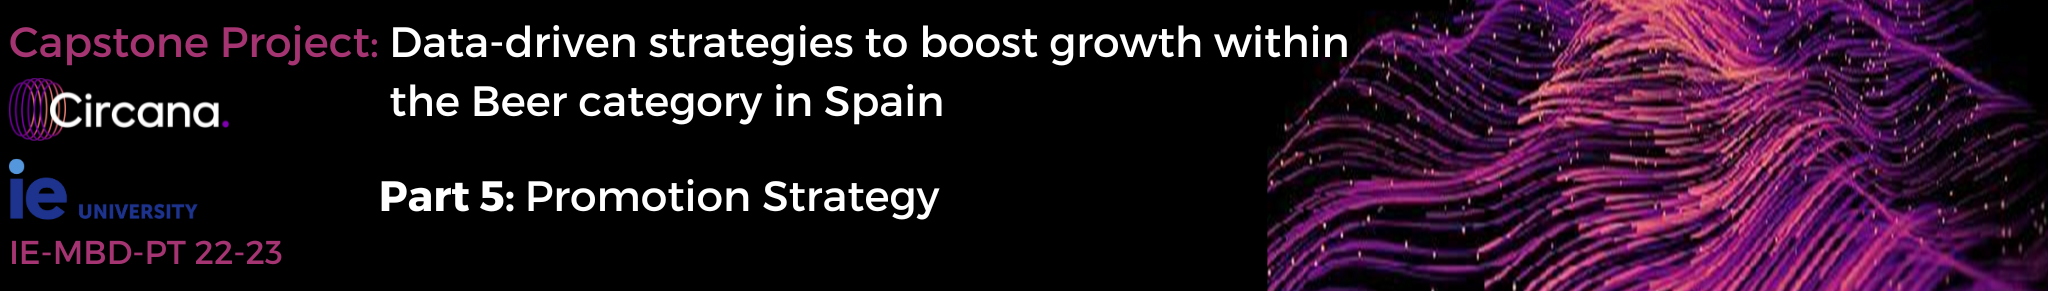

In [1]:
from IPython.display import Image
Image(filename='images/header-part5.png')

The aim of this exercise is to delve into the **characteristics of each of the promotions and their impacts** in a detailed and structured way. To this end, we will present a series of questions that we will answer with the analysis of the existing data in order to provide a clear vision of how we are applying the promotions and how they could be applied in order to achieve greater value.

## <span style="color: purple">**Table of contents**</span> <a class="anchor"></a>
- [<span style="color: purple">0. Preparing the environment</span>](#section_0)
- [<span style="color: purple">1. Preparing the data</span>](#section_1)
- [<span style="color: purple">2. Answering some initial questions</span>](#section_2)
  - [<span style="color: purple">2.1. How many sales in volume happened during promotions?</span>](#section_2_1)
  - [<span style="color: purple">2.2. What are the different types of promotions available?</span>](#section_2_2)
      - [<span style="color: purple">2.2.1 Performing A/B Testing</span>](#section_2_2_1)
  - [<span style="color: purple">2.3. What is the Average Duration of a promotion?</span>](#section_2_3)
      - [<span style="color: purple">2.3.1 What is the duration based on channel?</span>](#section_2_3_1)
      - [<span style="color: purple">2.3.2 What is the duration based on manufacturer?</span>](#section_2_3_2)
      - [<span style="color: purple">2.3.3 What is the duration based on segment?</span>](#section_2_3_3)
  - [<span style="color: purple">2.4. To what extent does the promotion help build category volume?​</span>](#section_2_4)
- [<span style="color: purple">3. Promotion Effectiveness: Backward-looking (Post-mortem)</span>](#section_3)
  - [<span style="color: purple">3.1. Promotion ROI </span>](#section_3_1)
- [<span style="color: purple">4. Sales uplift Driver Analysis</span>](#section_4)
  - [<span style="color: purple">4.1. Feature engineering for identifying promotion drivers</span>](#section_4_1)
      - [<span style="color: purple">4.1.1. Discount </span>](#section_4_1_1)
      - [<span style="color: purple">4.1.2. Running more than 1 promotion at a time </span>](#section_4_1_2)
      - [<span style="color: purple">4.1.3. Duration of the Promotion</span>](#section_4_1_3)
  - [<span style="color: purple">4.2. Correlation Analysis</span>](#section_4_2)
  - [<span style="color: purple">4.3. XGBoost for identifying the variables causing sales uplift</span>](#section_4_3)
- [<span style="color: purple">5. Deep-dive of the first Key Drivers of sales uplift</span>](#section_5)
  - [<span style="color: purple">5.1. Segment </span>](#section_5_1)
  - [<span style="color: purple">5.2. Volume</span>](#section_5_2)
  - [<span style="color: purple">5.3. Province </span>](#section_5_3)  
  - [<span style="color: purple">5.4. Packaging</span>](#section_5_4)
  - [<span style="color: purple">5.5. Discount </span>](#section_5_5)
  - [<span style="color: purple">5.6. Week Code </span>](#section_5_6)
- [<span style="color: purple">6. Promotion Effectiveness: identifying "value destroyers"</span>](#section_6)
  - [<span style="color: purple">6.1. Province </span>](#section_6_1)
  - [<span style="color: purple">6.2. Segment</span>](#section_6_2)
  - [<span style="color: purple">6.3. Packaging </span>](#section_6_3)  
  - [<span style="color: purple">6.4. Discount</span>](#section_6_4)
  - [<span style="color: purple">6.5. Week Code </span>](#section_6_5)

  

## <span style="color: purple">**0. Preparing the environment**</span> <a class="anchor" id="section_0"></a>

Let's now dig deeper, with the goal to examine the sales units for each manufacturer, both when promotions are active and when they are not.

In [2]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import squarify
import matplotlib
import plotly.express as px
from plotnine import *
from plotnine import ggplot, geom_map, aes, scale_fill_cmap, theme, labs
from IPython.display import display, HTML
import plotly.graph_objects as go
import missingno as msno
import xgboost as xgb
from sklearn.model_selection import train_test_split
import easygui
import string
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import chi2
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.io as pio

#to enable the inline plotting
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

import os

if not os.path.exists("images"):
    os.mkdir("images")

In [3]:
#Importing of initial datasets (csv files)
df_original = pd.read_csv('Datasets/circana_data.csv')
df_stores = pd.pandas.read_excel('Datasets/NEW_DICTIONARY.xlsx', sheet_name='Stores')
df_time = pd.read_excel('Datasets/NEW_DICTIONARY.xlsx', sheet_name='Time_Periods')
df_products = pd.read_excel('Datasets/NEW_DICTIONARY.xlsx', sheet_name='Products')
df_provinces = pd.read_excel('Datasets/NEW_DICTIONARY.xlsx', sheet_name='Provinces')
df_promotions = pd.read_excel('Datasets/NEW_DICTIONARY.xlsx', sheet_name='Promotions')
df_channels = pd.read_excel('Datasets/NEW_DICTIONARY.xlsx', sheet_name='Channels')

In [4]:
# # Define the Prism color palette
prism_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52','#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

## <span style="color: purple">**2. Data Preparation**</span> <a class="anchor" id="section_1"></a>

In [5]:
#We make a copy of the original dataset
df_pre = df_original.copy()

In [6]:
#Change name of week_code column in df_time to Week Code
df_time.rename(columns={'week_code':'Week Code'}, inplace=True)

In [7]:
#Change name of store code column in df_store to Store Code
df_stores.rename(columns={'store_code':'Store Code'}, inplace=True)

In [8]:
#Change name of product code column in df_products to Product Code
df_products.rename(columns={'product_code':'Product Code'}, inplace=True)

In [9]:
#We merge the df_pre with df_time
df = pd.merge(df_pre, df_time, on='Week Code', how='left')

In [10]:
#We add a column with the difference between real price in units and rate price in Units 
df['price_diff_units'] = df['Real price in units'] - df['Rate price in units']

In [11]:
#We define a function that we will use for EDA. The display() function will provide well-formatted tables. We are mainly using pandas to explore the datasets

def dataset_description(df_target):

    print('This is the Dataset shape: %s\n' % (df_target.shape, ))
    print('Dataset columns: %s\n' % df_target.columns)

    print('\nColumns description:\n')
    display(df_target.info())
    display(df_target.describe())  # describe the dataset

    print('\nNull values:\n')
    display(df_target.isnull().sum())  # Identify null values

In [12]:
dataset_description(df)

This is the Dataset shape: (5547705, 39)

Dataset columns: Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Real price in volume', 'Rate price in units',
       'Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'UNITS',
       'min temp', 'max temp', 'mean temp', 'precipitation', 'promotion',
       'holiday', 'population', 'liters/person', 'date', 'year',
       'price_diff_units'],
      dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5547705 entries, 0 to 5547704
Data columns (total 39 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Store Code            

None

Store Code     Week Code  Product Code  Sales in units  \
count  5.547705e+06  5.547705e+06  5.547705e+06    5.547705e+06   
mean   2.896980e+02  5.906245e+01  8.725088e+02    6.518518e+01   
min    1.000000e+00  1.000000e+00  4.000000e+00    0.000000e+00   
25%    1.580000e+02  3.000000e+01  5.180000e+02    3.000000e+00   
50%    2.820000e+02  6.000000e+01  9.270000e+02    1.000000e+01   
75%    4.450000e+02  8.800000e+01  1.226000e+03    3.000000e+01   
max    5.570000e+02  1.160000e+02  1.505000e+03    1.748640e+05   
std    1.631150e+02  3.329492e+01  4.048255e+02    7.599689e+02   

       Sales in value (€)  Sales in volume (Lt)  Number of references  \
count        5.547705e+06          5.547705e+06             5547705.0   
mean         5.982207e+01          4.982284e+01                   1.0   
min          2.000000e-02          0.000000e+00                   1.0   
25%          5.400000e+00          2.000000e+00                   1.0   
50%          1.363000e+01          7.000000e+00                   1.0   
75%          3.621000e+01          2.200000e+01                   1.0   
max          6.803865e+04          5.770500e+04                   1.0   
std          2.966364e+02          3.478135e+02                   0.0   

       Real price in units  Real price in volume  Rate price in units  ...  \
count         5.547705e+06          5.547705e+06         5.547705e+06  ...   
mean          2.174584e+00          1.208144e+00         2.314883e+00  ...   
min           1.000000e-02          2.000000e-01         1.000000e-02  ...   
25%           6.100000e-01          3.300000e-01         6.500000e-01  ...   
50%           1.200000e+00          3.600000e-01         1.280000e+00  ...   
75%           2.660000e+00          1.500000e+00         2.760000e+00  ...   
max           1.390000e+02          5.000000e+01         1.408500e+02  ...   
std           2.455235e+00          1.603819e+00         2.712407e+00  ...   

              UNITS      min temp      max temp     mean temp  precipitation  \
count  5.547705e+06  5.547705e+06  5.547705e+06  5.547705e+06   5.547705e+06   
mean   3.758150e+00  1.136531e+01  1.979015e+01  1.532159e+01   1.826649e+00   
min    1.000000e+00 -4.242857e+00  1.914286e+00 -1.114286e+00   0.000000e+00   
25%    1.000000e+00  6.514286e+00  1.411429e+01  1.004286e+01   1.000000e-01   
50%    1.000000e+00  1.048571e+01  1.848571e+01  1.428571e+01   7.142857e-01   
75%    6.000000e+00  1.658571e+01  2.547143e+01  2.064286e+01   2.400000e+00   
max    2.800000e+01  2.594286e+01  4.048571e+01  3.217143e+01   3.682857e+01   
std    5.247237e+00  6.344417e+00  7.269857e+00  6.773352e+00   2.730579e+00   

            holiday    population  liters/person  \
count  5.547705e+06  5.547705e+06   5.547705e+06   
mean   5.400502e-01  1.107074e+06   7.236401e-05   
min    0.000000e+00  6.774700e+04   0.000000e+00   
25%    0.000000e+00  5.304360e+05   2.506655e-06   
50%    0.000000e+00  9.605740e+05   8.116625e-06   
75%    1.000000e+00  1.468540e+06   2.872157e-05   
max    5.000000e+00  5.200460e+06   1.928024e-01   
std    8.987944e-01  8.435107e+05   6.683428e-04   

                                date  price_diff_units  
count                        5547705      5.547705e+06  
mean   2022-02-13 10:29:28.541478912     -1.402996e-01  
min              2021-01-03 00:00:00     -1.353100e+02  
25%              2021-07-25 00:00:00     -8.000000e-02  
50%              2022-02-20 00:00:00      0.000000e+00  
75%              2022-09-04 00:00:00      0.000000e+00  
max              2023-03-19 00:00:00      1.670000e+00  
std                              NaN      7.906644e-01  

[8 rows x 29 columns]


Null values:



Store Code                      0
Week Code                       0
Product Code                    0
Sales in units                  0
Sales in value (€)              0
Sales in volume (Lt)            0
Number of references            0
Real price in units             0
Real price in volume            0
Rate price in units             0
Rate price in volume            0
Month                           0
Year                            0
Season                          0
Quarter                         0
channel_code                    0
province code                   0
postal_code                     0
sales_surface_sqmeters          0
Province                        0
Autonomus Community             0
Channel                         0
SEGMENT                         0
MANUFACTURER                    0
BRAND                           0
PACKAGING                       0
VOLUME                          0
UNITS                           0
min temp                        0
max temp      

## <span style="color: purple">**2. Answering some initial questions**</span> <a class="anchor" id="section_2"></a>

## <span style="color: purple">2.1 How many sales in volume happened during promotions?</span> <a class="anchor" id="section_2_1"></a>

In [13]:
#We start by adding a column to the df if the product is on a promo or not
df['is_promo'] = df['promotion'].apply(lambda x: 0 if pd.isnull(x) else 1).astype(str)

In [14]:
#We create df_promo_year by aggregating sales units based on is_promo and year
df_promo_year = df.groupby(['is_promo', 'year'])['Sales in units'].sum().reset_index()
#Calculate the total sales per year
df_total_year = df.groupby('year')['Sales in units'].sum().reset_index()
#Merge df_promo_year and df_total_year on the 'year' column
df_promo_year = df_promo_year.merge(df_total_year, on='year', suffixes=('', '_total'))
#Calculate the percentage of total sales per year
df_promo_year['Percentage of Total'] = (df_promo_year['Sales in units'] / df_promo_year['Sales in units_total']) * 100
#Drop the 'Sales in units_total' column
df_promo_year = df_promo_year.drop('Sales in units_total', axis=1)

#Plot the sales units by year and is_promo in a bar chart
fig = px.bar(df_promo_year, x="year", y="Sales in units", color="is_promo", barmode="group",
             title="Sales Units by Year and is promo or not", text='Percentage of Total',color_discrete_sequence=px.colors.qualitative.Plotly)

#Add percentage labels to the bars
fig.update_traces(texttemplate='%{text:.2f}%', textposition='inside')

# Save the plot as an HTML file
pio.write_html(fig, 'images/Sales_Units_by_Year_and_is_promo_or_not.html', auto_open=False)

In [15]:
#Create df_promo_year by aggregating sales units based on is_promo and year
df_promo_total = df.groupby(['is_promo'])['Sales in units'].sum().reset_index()
#Add column to dataframe with total sales in units
df_promo_total['Total Sales in units'] = df['Sales in units'].sum()
#Calculate the percentage of total sales per year
df_promo_total['Percentage of Total'] = (df_promo_total['Sales in units'] / df_promo_total['Total Sales in units']) * 100
#Drop the 'Sales in units_total' column
df_promo_total = df_promo_total.drop('Total Sales in units', axis=1)
df_promo_total

is_promo  Sales in units  Percentage of Total
0        0       115056212            31.816164
1        1       246571955            68.183836

In [16]:
#By how much do sales increase when a product is on promotion
(df_promo_total['Percentage of Total'].iloc[1] / df_promo_total['Percentage of Total'].iloc[0])-1


1.1430564305384916

In [17]:
#Now, we plot the sales units by year and is_promo in a bar chart
fig = px.bar(df_promo_total, x="is_promo", y="Sales in units", color="is_promo",
                title="Sales units by is promo or not", text='Percentage of Total',color_discrete_sequence=px.colors.qualitative.Plotly)
#Add percentage labels to the bars
fig.update_traces(texttemplate='%{text:.2f}%', textposition='inside')

# Save the plot as an HTML file
pio.write_html(fig, 'images/Sales_units_by_is_promo_or_not.html', auto_open=False)

## <span style="color: purple">2.2. What are the different type of promotions available?</span> <a class="anchor" id="section_2_2"></a>

In [18]:
#We create a dataframe with promotions type and percentage distribution
promo_type = df.groupby('promotion')['promotion'].count().reset_index(name='count')
promo_type['% distribution'] = promo_type['count']/promo_type['count'].sum()
promo_type['% distribution']= pd.Series(["{0:.2f}%".format(val * 100) for val in promo_type['% distribution']], index = promo_type.index)
promo_type

promotion    count % distribution
0        Promo cabecera   150926          8.22%
1       Promo descuento  1172705         63.85%
2       Promo expositor   129971          7.08%
3  Promo extra cantidad     7465          0.41%
4         Promo folleto   266901         14.53%
5            Promo isla    40722          2.22%
6     Promo multicompra    39188          2.13%
7          Promo regalo    28874          1.57%

In [19]:
#Create the bar chart using Plotly
fig = go.Figure(data=[
    go.Bar(
        x=promo_type['promotion'],
        y=promo_type['count'],
        text=promo_type['% distribution'],
        textposition='auto',
        marker=dict(color=prism_colors)
    )
])

#Add axis labels and title
fig.update_layout(
    xaxis_title='Promotion Type',
    yaxis_title='Total Promotions',
    title='Total Promotions per type'
)

# Save the plot as an HTML file
pio.write_html(fig, 'images/Total_Promotions_per_type.html', auto_open=False)

In [20]:
df_promo_type_units = df.groupby(['promotion'])['Sales in units'].sum().reset_index()
df_promo_type_units['Total Sales in units'] = df_promo_type_units['Sales in units'].sum()
df_promo_type_units['Percentage of Total'] = (df_promo_type_units['Sales in units'] / df_promo_type_units['Total Sales in units'])
df_promo_type_units['Percentage of Total']= pd.Series(["{0:.2f}%".format(val * 100) for val in df_promo_type_units['Percentage of Total']], index = df_promo_type_units.index)
df_promo_type_units = df_promo_type_units.drop('Total Sales in units', axis=1)
df_promo_type_units

promotion  Sales in units Percentage of Total
0        Promo cabecera        32170543              13.05%
1       Promo descuento       111617596              45.27%
2       Promo expositor        26440289              10.72%
3  Promo extra cantidad          404969               0.16%
4         Promo folleto        50867805              20.63%
5            Promo isla         2734253               1.11%
6     Promo multicompra        21646583               8.78%
7          Promo regalo          689917               0.28%

In [21]:
import plotly.graph_objects as go

# Create the bar chart using Plotly
fig = go.Figure(data=[
    go.Bar(
        x=df_promo_type_units['promotion'],
        y=df_promo_type_units['Sales in units'],
        text=df_promo_type_units['Percentage of Total'],
        textposition='auto',
        marker=dict(color=prism_colors)
    )
])

# Add axis labels and title
fig.update_layout(
    xaxis_title='Promotion Type',
    yaxis_title='Total Promotions',
    title='Sales in Units Promotions per type'
)

# Save the plot as an HTML file
pio.write_html(fig, 'images/Sales_in_Units_Promotions_per_type.html', auto_open=False)

### <span style="color: purple">2.2.1 Performing A/B Testing</span> <a class="anchor" id="section_2_2_1"></a>

In [22]:
means = df.groupby(['promotion'])['Sales in units'].mean()
stds = df.groupby(['promotion'])['Sales in units'].std()
ns = df.groupby(['promotion'])['Sales in units'].count()

In [23]:
print(means)
print(stds)
print(ns) #Number of samples

promotion
Promo cabecera          213.154413
Promo descuento          95.179603
Promo expositor         203.432219
Promo extra cantidad     54.249029
Promo folleto           190.586791
Promo isla               67.144369
Promo multicompra       552.377845
Promo regalo             23.894057
Name: Sales in units, dtype: float64
promotion
Promo cabecera          1524.715440
Promo descuento         1021.349393
Promo expositor         1491.392076
Promo extra cantidad     417.946276
Promo folleto           1645.720045
Promo isla               280.304686
Promo multicompra       3472.765730
Promo regalo             548.737028
Name: Sales in units, dtype: float64
promotion
Promo cabecera           150926
Promo descuento         1172705
Promo expositor          129971
Promo extra cantidad       7465
Promo folleto            266901
Promo isla                40722
Promo multicompra         39188
Promo regalo              28874
Name: Sales in units, dtype: int64


At this point, we want to statistically test if a significant difference really exists in between 2 of the groups of promos. For that, we will use T-Test and P-Value.

**T-Value**
The t-value measures the degree of difference relative to the variation in our data groups. Large t-values indicate a higher degree of difference between the groups

**P-Value**
The P-value measures the probability that the results would occur by random chance. Therefore, the smaller the p-value is, the more statistically significant the difference there will be between the two groups

In [24]:
#We compute the t an p values using scipy
from scipy import stats 

t, p = stats.ttest_ind(df.loc[df['promotion'] == 'Promo descuento', 'Sales in units'].values,
                       df.loc[df['promotion'] == 'Promo folleto', 'Sales in units'].values,
                       equal_var=False)

print("t-value = " +str(t))
print("p-value = " +str(p))

t-value = -28.717973537008433
p-value = 3.904884962387243e-181


**Analysis of P and T-Values**

- Our P-Value is close 0 which suggests that there is good evidence to REJECT the Null Hypothesis -- meaning that there is a statistical difference between the two compared groups.

- Our threshold for rejecting the null hypothesis is usually less than 0.05

- Our t-test show that thes marketing performances for these two groups are significantly different and that **promo descuento out-performs promotion group promo folleto**.


## <span style="color: purple">2.3. What is the Average Duration of a promotion?</span> <a class="anchor" id="section_2_3"></a>

In [25]:
#Create a dataframe only for promotions
df_promo = df[df['is_promo'] == '1']

In [26]:
#We count the number of consecutive weeks a product is on promotion in a store. Then, we group the promos by week and count them
consecutive_promo_temp = df_promo.groupby(['Store Code', 'Product Code', 'promotion', 'Week Code'])['promotion'].count().reset_index(name='count')
consecutive_promo  = consecutive_promo_temp [['Store Code', 'Product Code', 'promotion','Week Code']].copy()

In [27]:
#First, let's copy the data we're going to use to another dataframe. Let's also create a column of zeros, that will be used later
consecutive_weeks_with_promo = consecutive_promo[['Store Code', 'Product Code', 'promotion','Week Code']].copy()
consecutive_weeks_with_promo["zeros"] = 0

In [28]:
#To make it easy to calculate the difference between the rows, let's convert the "promotion_type" column to numbers
consecutive_weeks_with_promo["promotion"] = consecutive_weeks_with_promo["promotion"].rank(method='dense')
consecutive_weeks_with_promo = consecutive_weeks_with_promo.sort_values(['Store Code', 'Product Code', 'promotion','Week Code'], ascending=[True, True, True, True])

In [29]:
#Since we want to do this operation per store code and product, we need to use groupby. Then, we can diff() this to get the difference between consecutive rows in a group.
groups = consecutive_weeks_with_promo.groupby(['Store Code', 'Product Code'])
group_diff = groups.diff()

In [30]:
#Now, we want to increment the value of df["duration"] for only those rows where group_diff["date"] is 7 days and group_diff["promotion_type"] is zero. Let's set the zeros column of the df_data for these rows to one
filt = (group_diff["Week Code"] == 1) & (group_diff["promotion"] == 0)
consecutive_weeks_with_promo.loc[filt, "zeros"] = 1

In [31]:
promo_duration= consecutive_weeks_with_promo[['Store Code', 'Product Code', 'promotion','Week Code','zeros']].groupby(["Store Code","Product Code", "promotion"]).cumsum()

In [32]:
consecutive_promo["duration"] = promo_duration['zeros']+1

In [33]:
#Average duration by promotion type
duration=consecutive_promo.groupby(['Store Code', 'Product Code', 'promotion'])['duration'].max().reset_index(name='max_duration')
#Sort consecutive_promo by average duration
duration.sort_values(by=['max_duration'], ascending=False)

Store Code  Product Code        promotion  max_duration
49996          183          1031   Promo cabecera           116
29976          113           923  Promo expositor           114
22885           87          1031   Promo cabecera           111
23744           91           976   Promo cabecera           111
84396          292          1031   Promo cabecera           109
...            ...           ...              ...           ...
52021          192          1505  Promo expositor             1
52014          192          1502   Promo cabecera             1
52012          192          1500  Promo expositor             1
128398         461          1502  Promo expositor             1
0                1           222   Promo cabecera             1

[163214 rows x 4 columns]

In [36]:
#Plot distribution of duration
fig = px.histogram(duration, x="max_duration", color="promotion", marginal="box", hover_data=duration.columns,
                     title ="Distribution of Duration by Promotion Type")
# Save the plot as an HTML file
pio.write_html(fig, 'images/Distribution_of_Duration_by_Promotion_Type_not.html', auto_open=False)

In [37]:
#Consolidate average, min and max duration by promotion type
duration_stats=consecutive_promo.groupby(['promotion'])['duration'].mean().reset_index(name='avg_duration')
duration_stats['max_duration'] = consecutive_promo.groupby(['promotion'])['duration'].max().reset_index(name='max_duration')['max_duration']
duration_stats['min_duration'] = consecutive_promo.groupby(['promotion'])['duration'].min().reset_index(name='min_duration')['min_duration']
decimals = 2
duration_stats['avg_duration'] = duration_stats['avg_duration'].apply(lambda x: round(x, decimals))
duration_stats['max_duration'] = duration_stats['max_duration'].apply(lambda x: round(x, decimals))
duration_stats['min_duration'] = duration_stats['min_duration'].apply(lambda x: round(x, decimals))
duration_stats

promotion  avg_duration  max_duration  min_duration
0        Promo cabecera          9.86           116             1
1       Promo descuento         11.41           107             1
2       Promo expositor          7.78           114             1
3  Promo extra cantidad         17.00           107             1
4         Promo folleto          6.66            46             1
5            Promo isla          8.18           104             1
6     Promo multicompra          4.99            81             1
7          Promo regalo          7.96           100             1

In [38]:
#Box plot of duration by promotion type
fig = px.box(consecutive_promo, x="promotion", y="duration", color="promotion", notched=True,
                title="Box plot of Duration by Promotion Type")
# Save the plot as an HTML file
pio.write_html(fig, 'images/Box_plot_Duration_by_Promotion_Type.html', auto_open=False)

In [39]:
#Let's plot the average duration by promotion type using plotly

fig = go.Figure(data=[
    go.Bar(

        x=duration_stats['promotion'],
        y=duration_stats['avg_duration'],
        text=duration_stats['avg_duration'],
        textposition='auto',
        marker=dict(color=prism_colors)
    )
])

fig.update_layout(
    xaxis_title='Promotion Type',
    yaxis_title='Average Duration',
    title='Average Duration per type'
)

# Save the plot as an HTML file
pio.write_html(fig, 'images/Average_duration_per_type.html', auto_open=False)


With that, we are able to identify the average duration of a promation, depending on the type of promotion. Now, we will drill down to extract more value, seeing how these durations evolve based on channel, manufacturer and segment.

### <span style="color: purple">2.3.1. What is the duration based on channel?</span> <a class="anchor" id="section_2_3_1"></a>

In [40]:
#First we merge the duration with the store data
duration_store = pd.merge(duration, df_stores, on='Store Code', how='left')
duration_channel = pd.merge(duration_store, df_channels, on='channel_code', how='left')

In [41]:
#We Group duration_channel by promotion and Channel
duration_channel_stats=duration_channel.groupby(['promotion','Channel'])['max_duration'].mean().reset_index(name='avg_duration')

In [42]:
#Now, let's plot the average duration of each promotion type depending on the channel
import plotly.express as px

fig = px.histogram(
    duration_channel_stats,
    x='Channel',
    y='avg_duration',
    color='promotion',
    barmode='group',
    labels={'avg_duration': 'Average Duration'},
    hover_data={'avg_duration': ':.2f'}
)

fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
fig.update_layout(title='Average Duration by Channel Name', xaxis_title='Channel Name', yaxis_title='Average Duration')

# Save the plot as an HTML file
pio.write_html(fig, 'images/Average_duration_per_Channel.html', auto_open=False)


In [43]:
#We will run an statistical test to see if average duration difference by channel (focusing on Hipermarkets and Supermarkets) is statistically significant
import scipy.stats as stats

hiper = duration_channel_stats[duration_channel_stats.Channel == 'Hipermarkets']
super = duration_channel_stats[duration_channel_stats.Channel == 'Supermarkets']

#Again, we will compute the t-value and the p-value
t, p = stats.ttest_ind(hiper['avg_duration'], super['avg_duration'])

if p < 0.05:
    print('There is a significant difference between hipermarkets and supermarkets in terms of average duration')
else:
    print('There is no significant difference between hipermarkets and supermarkets in terms of average duration')


There is no significant difference between hipermarkets and supermarkets in terms of average duration


### <span style="color: purple">2.3.2. What is the duration based on manufacturer?</span> <a class="anchor" id="section_2_3_2"></a>

In [44]:
#Merge the duration with the store data
duration_product = pd.merge(duration, df_products, on='Product Code', how='left')

In [45]:
#Group duration_channel by promotion and manufacturer
duration_manufacturer_stats=duration_product.groupby(['promotion','product_manufacturer'])['max_duration'].mean().reset_index(name='avg_duration')

In [46]:
#Now, let's plot the average duration of each promotion type depending on the manufacturer
fig = px.histogram(
    duration_manufacturer_stats,
    x='product_manufacturer',
    y='avg_duration',
    color='promotion',
    barmode='group',
    labels={'avg_duration': 'Average Duration'},
    hover_data={'avg_duration': ':.2f'}
)

fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
fig.update_layout(title='Average Duration by Manufacturer', xaxis_title='Manufacturer', yaxis_title='Average Duration')

# Save the plot as an HTML file
pio.write_html(fig, 'images/Average_duration_per_manufacturer.html', auto_open=False)


### <span style="color: purple">2.3.3. What is the duration based on segment?</span> <a class="anchor" id="section_2_3_3"></a>

In [47]:
#Group duration_channel by promotion and segment
duration_segment_stats=duration_product.groupby(['promotion','product_segment'])['max_duration'].mean().reset_index(name='avg_duration')

In [48]:
#Now, let's plot the average duration of each promotion type depending on the segment
fig = px.histogram(
    duration_segment_stats,
    x='product_segment',
    y='avg_duration',
    color='promotion',
    barmode='group',
    labels={'avg_duration': 'Average Duration'},
    hover_data={'avg_duration': ':.2f'}
)

fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
fig.update_layout(title='Average Duration by Segment', xaxis_title='Segment', yaxis_title='Average Duration')

# Save the plot as an HTML file
pio.write_html(fig, 'images/Average_duration_per_segment.html', auto_open=False)


## <span style="color: purple">2.4. To what extent does the promotion help build category volume?</span> <a class="anchor" id="section_2_4"></a>

In [49]:
#First, we create a new dataframe for promotions and manufacturer
#Group by 'MANUFACTURER' and 'promotion' columns and calculate the count
promo_type_man = df.groupby(['MANUFACTURER','promotion'])['promotion'].count().reset_index(name='count')
#Calculate the percentage distribution
promo_type_man['% distribution'] = promo_type_man.groupby('MANUFACTURER')['count'].transform(lambda x: (x / x.sum()) * 100)
promo_type_man['% distribution'] = promo_type_man['% distribution'].round(2)


print(promo_type_man)
    

           MANUFACTURER             promotion   count  % distribution
0        MANUFACTURER 1        Promo cabecera   14398            8.05
1        MANUFACTURER 1       Promo descuento  127194           71.13
2        MANUFACTURER 1       Promo expositor    9569            5.35
3        MANUFACTURER 1  Promo extra cantidad      26            0.01
4        MANUFACTURER 1         Promo folleto   20322           11.36
5        MANUFACTURER 1            Promo isla    4485            2.51
6        MANUFACTURER 1     Promo multicompra    2445            1.37
7        MANUFACTURER 1          Promo regalo     389            0.22
8        MANUFACTURER 2        Promo cabecera   50394            9.30
9        MANUFACTURER 2       Promo descuento  341109           62.96
10       MANUFACTURER 2       Promo expositor   38894            7.18
11       MANUFACTURER 2  Promo extra cantidad    2503            0.46
12       MANUFACTURER 2         Promo folleto   76340           14.09
13       MANUFACTURE

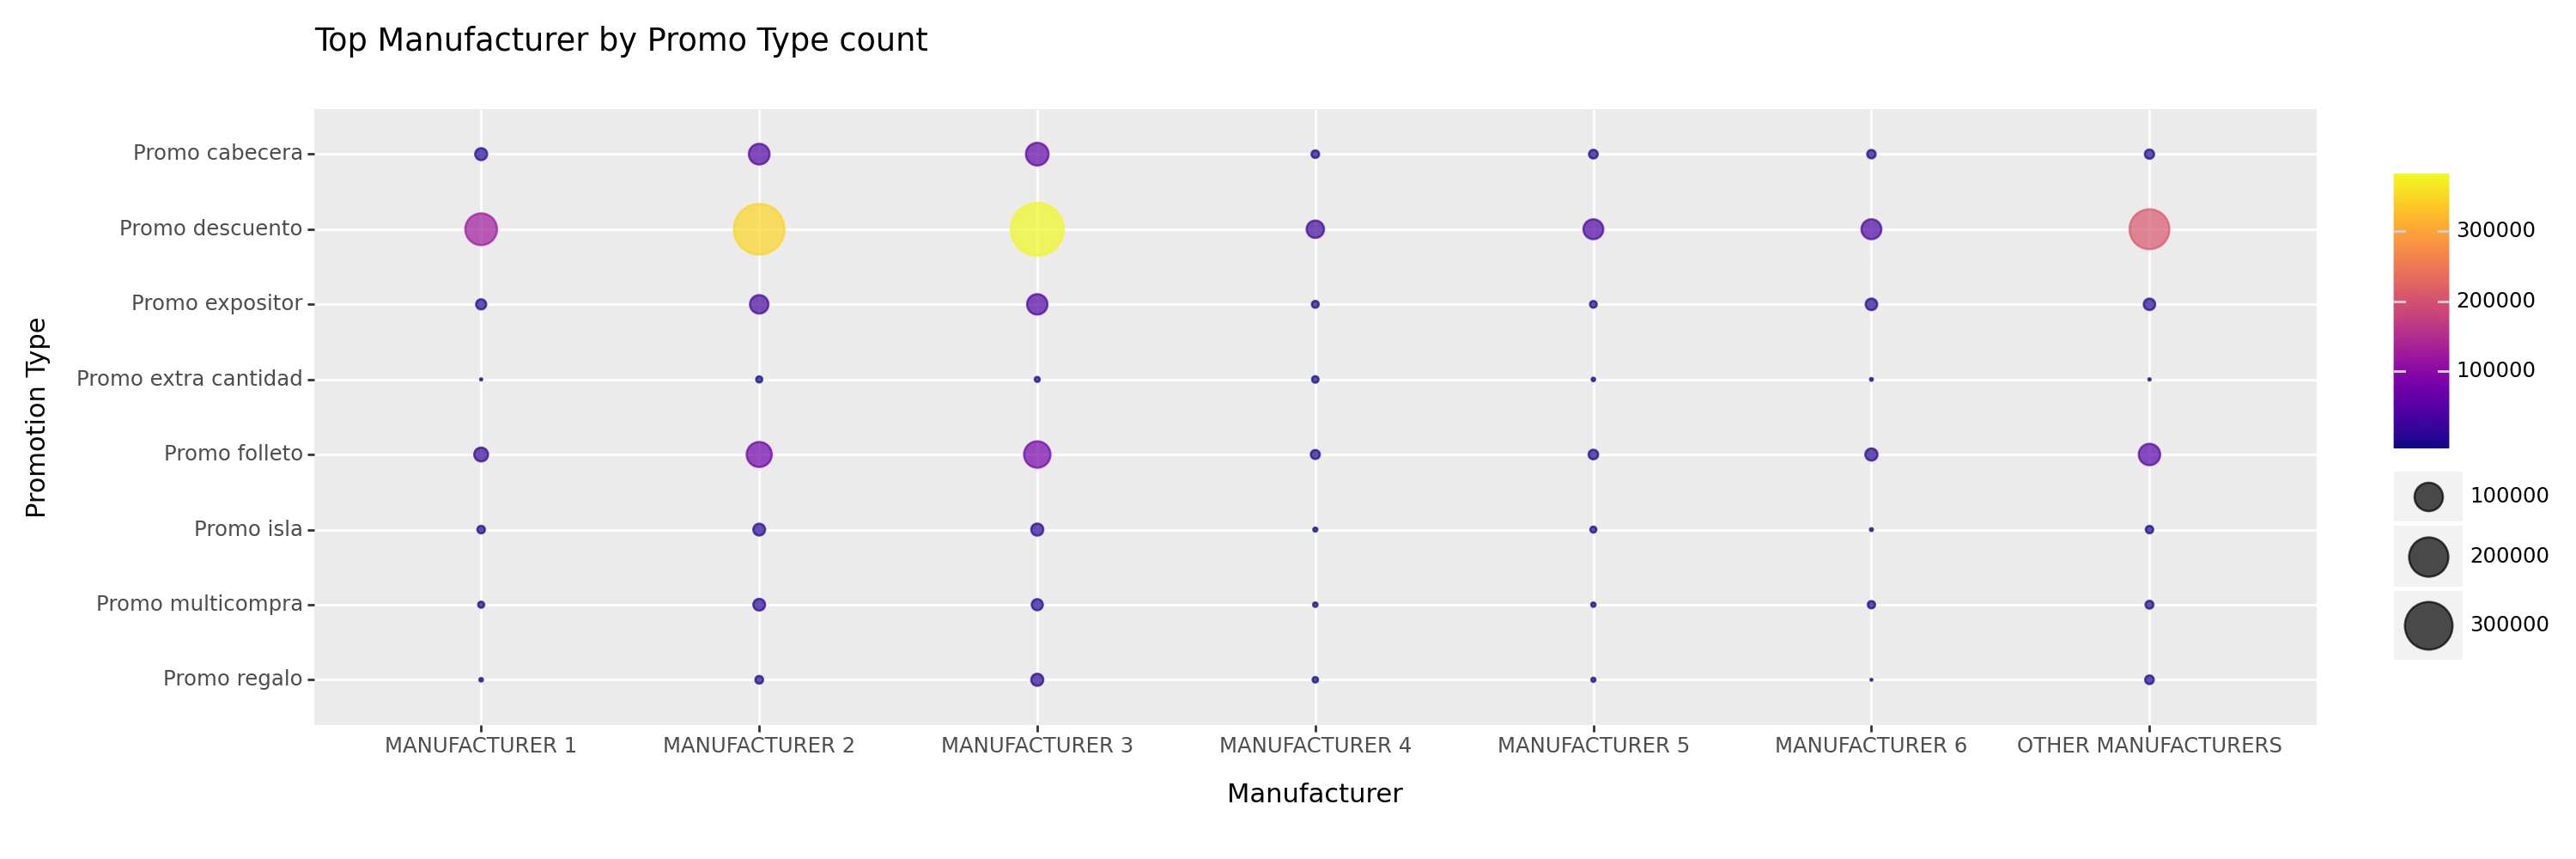

<Figure Size: (1500 x 500)>

In [50]:
#We plot the distribution of promotion types by manufacturer
ggplot(promo_type_man , aes(x='MANUFACTURER', y='promotion')) +\
  geom_point(aes(size='count', color='count'),alpha = 0.7)+\
    theme(legend_title = element_blank())+\
      scale_color_cmap(cmap_name="plasma")+\
          scale_y_discrete(limits=reversed)+\
            scale_size(range=(0,12))+\
              ggtitle("Top Manufacturer by Promo Type count")+\
                labs(y= "Promotion Type", x = "Manufacturer")+\
                  theme(figure_size=(15, 5))

In [51]:
#Sales Units by manufacturer and promotion type
df_promo_type_man_units = df.groupby(['MANUFACTURER','promotion'])['Sales in units'].sum().reset_index()
df_promo_type_man_units['Total Sales in units'] = df_promo_type_man_units['Sales in units'].sum()
df_promo_type_man_units['Percentage of Total'] = (df_promo_type_man_units['Sales in units'] / df_promo_type_man_units['Total Sales in units'])
df_promo_type_man_units['Percentage of Total']= pd.Series(["{0:.2f}%".format(val * 100) for val in df_promo_type_man_units['Percentage of Total']], index = df_promo_type_man_units.index)
df_promo_type_man_units = df_promo_type_man_units.drop('Total Sales in units', axis=1)

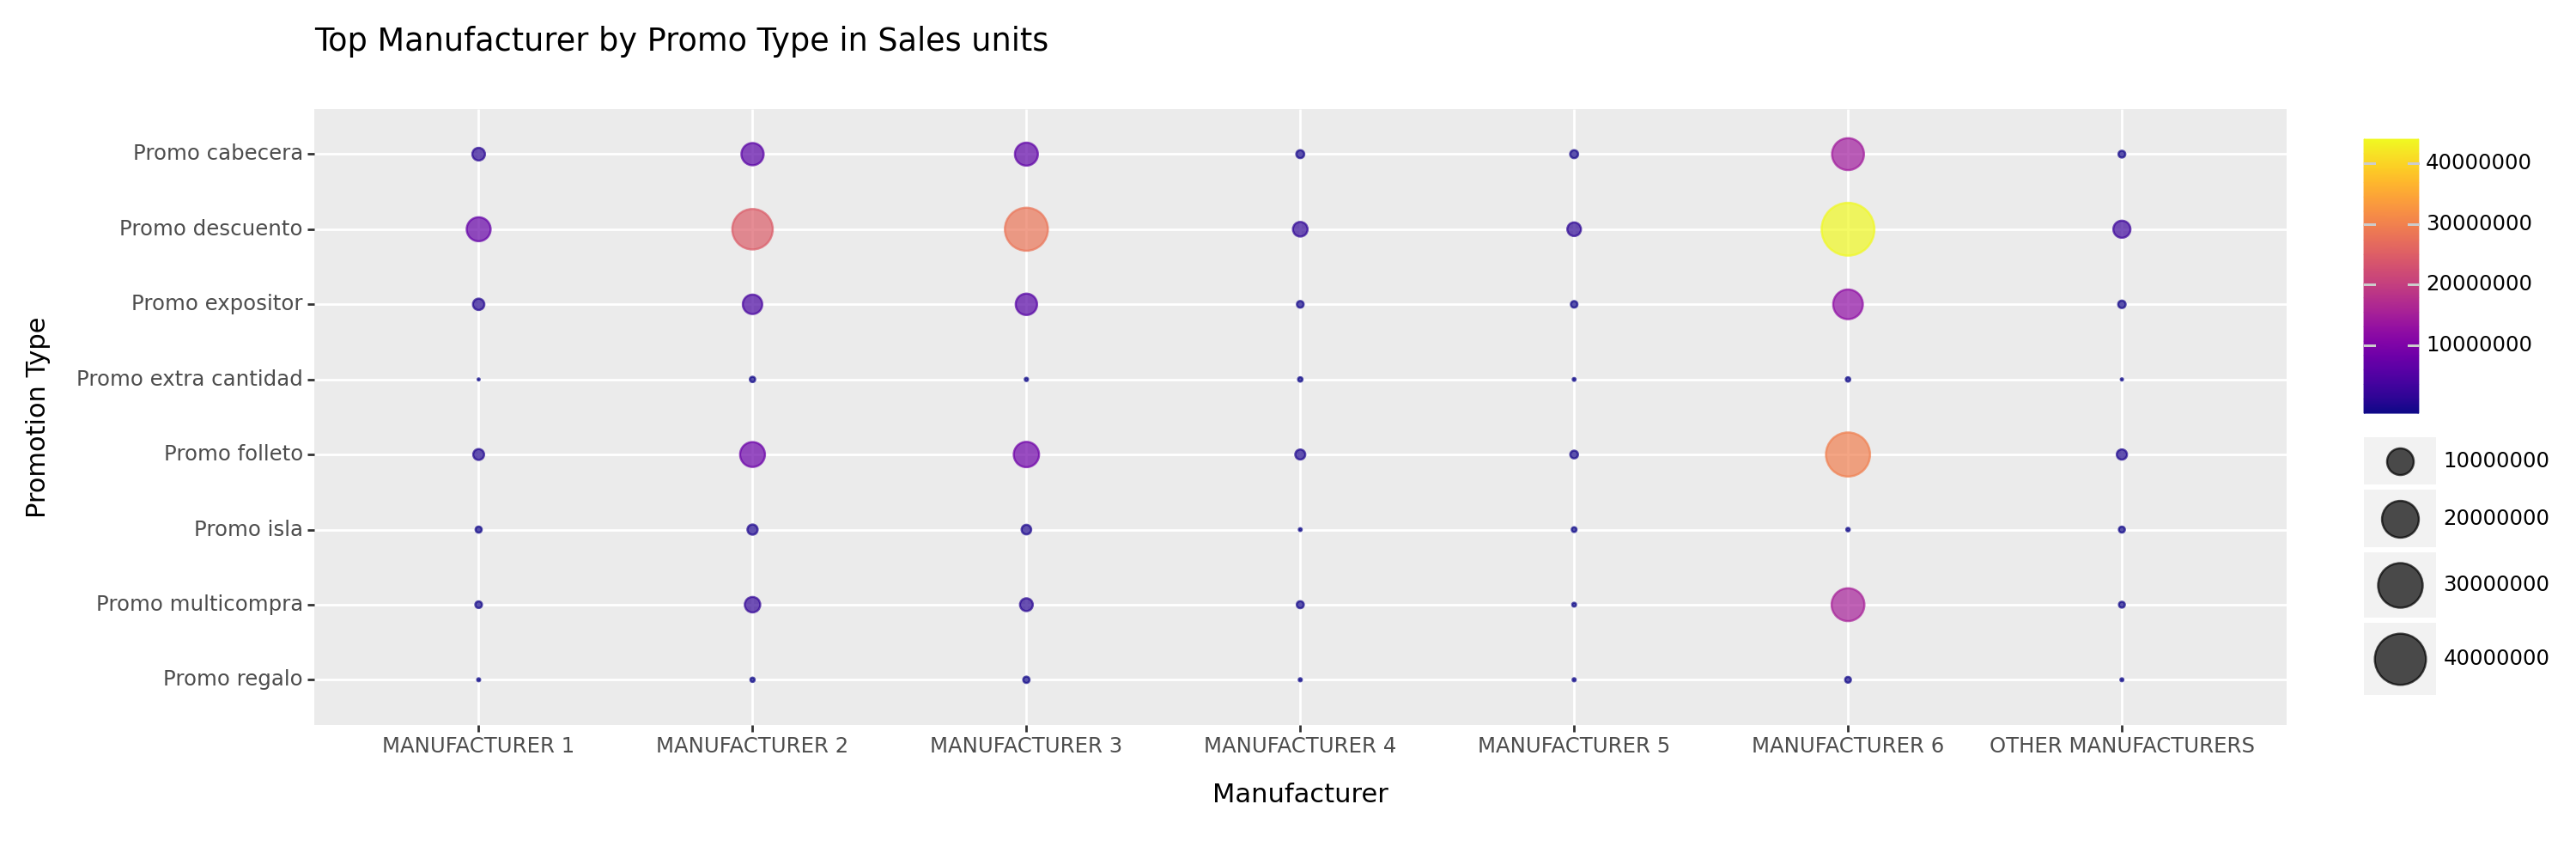

<Figure Size: (1500 x 500)>

In [52]:
#Now, we plot the distribution of sales units by promotion type and manufacturer
ggplot(df_promo_type_man_units , aes(x='MANUFACTURER', y='promotion')) +\
  geom_point(aes(size='Sales in units', color='Sales in units'),alpha = 0.7)+\
    theme(legend_title = element_blank())+\
      scale_color_cmap(cmap_name="plasma")+\
          scale_y_discrete(limits=reversed)+\
            scale_size(range=(0,12))+\
              ggtitle("Top Manufacturer by Promo Type in Sales units ")+\
                labs(y= "Promotion Type", x = "Manufacturer")+\
                  theme(figure_size=(15, 5))

Let's now dig deeper, with the goal to examine the sales units for each manufacturer, both when promotions are active and when they are not.

In [53]:
#Create df_promo_year by aggregating sales units based on is_promo and manufacturer
df_promo_man = df.groupby(['is_promo', 'MANUFACTURER'])['Sales in units'].sum().reset_index()
#Calculate the total sales per year
df_total_man = df.groupby('MANUFACTURER')['Sales in units'].sum().reset_index()
#Merge df_promo_year and df_total_year on the 'year' column
df_promo_man = df_promo_man.merge(df_total_man, on='MANUFACTURER', suffixes=('', '_total'))
#Calculate the percentage of total sales per year
df_promo_man['Percentage of Total'] = (df_promo_man['Sales in units'] / df_promo_man['Sales in units_total']) * 100
#Drop the 'Sales in units_total' column
df_promo_man = df_promo_man.drop('Sales in units_total', axis=1)

#Plot the sales units by year and is_promo in a bar chart
fig = px.bar(df_promo_man, x="MANUFACTURER", y="Sales in units", color="is_promo", barmode="group",
             title="Sales units by year and is promo or not", text='Percentage of Total',color_discrete_sequence=px.colors.qualitative.Plotly)

#Add percentage labels to the bars
fig.update_traces(texttemplate='%{text:.2f}%', textposition='inside')

# Save the plot as an HTML file
pio.write_html(fig, 'images/Sales_units_by_year_and_is_promo_or_not.html', auto_open=False)

Now, we will examine sales units for each segment, both when promotions are active and when they are not.

In [54]:
# Create df_promo_year by aggregating sales units based on is_promo and Segment
df_promo_seg = df.groupby(['is_promo', 'SEGMENT'])['Sales in units'].sum().reset_index()
# Calculate the total sales per year
df_total_seg = df.groupby('SEGMENT')['Sales in units'].sum().reset_index()
# Merge df_promo_year and df_total_year on the 'year' column
df_promo_seg = df_promo_seg.merge(df_total_seg, on='SEGMENT', suffixes=('', '_total'))
# Calculate the percentage of total sales per year
df_promo_seg['Percentage of Total'] = (df_promo_seg['Sales in units'] / df_promo_seg['Sales in units_total']) * 100
# Drop the 'Sales in units_total' column
df_promo_seg = df_promo_seg.drop('Sales in units_total', axis=1)

# Plot the sales units by year and is_promo in a bar chart
fig = px.bar(df_promo_seg, x="SEGMENT", y="Sales in units", color="is_promo", barmode="group",
             title="Sales units by year and is promo or not", text='Percentage of Total',color_discrete_sequence=px.colors.qualitative.Plotly)

# Add percentage labels to the bars
fig.update_traces(texttemplate='%{text:.2f}%', textposition='inside')

# Save the plot as an HTML file
pio.write_html(fig, 'images/Sales_units_by_year_and_is_promo_or_not_segment.html', auto_open=False)

We will now try to unfold more insights, looking at the total sales in units evolution through time, differentiating between sales with and without promotions.

In [55]:
#We plot a graph that can provide us with the information on how sales with and without promotions are evolving over time

#Create df_promo_year by aggregating sales units based on is_promo and date
df_promo_date = df.groupby(['is_promo', 'date'])['Sales in units'].sum().reset_index()
#Calculate the total sales per date
df_total_date = df.groupby('date')['Sales in units'].sum().reset_index()
#Merge df_promo_date and df_total_date on the 'date' column
df_promo_date = df_promo_date.merge(df_total_date, on='date', suffixes=('', '_total'))
#Calculate the percentage of total sales per date
df_promo_date['Percentage of Total'] = (df_promo_date['Sales in units'] / df_promo_date['Sales in units_total']) * 100
#Drop the 'Sales in units_total' column
df_promo_date = df_promo_date.drop('Sales in units_total', axis=1)

#Plot the sales units by date and is_promo in a line chart
fig = px.line(df_promo_date, x="date", y="Sales in units", color="is_promo",
             title="Sales units by date and is promo or not",color_discrete_sequence=px.colors.qualitative.Plotly)

# Save the plot as an HTML file
pio.write_html(fig, 'images/Sales_units_promo_or_not_segment.html', auto_open=False)

From the following graph, we can extract that specially, units sold under promotion are evolving through time. In the next code, we will calculate the average difference between promo and non-promo days by year and month, checking when most of the promotions are happening.

In [56]:
#Calculate average sales volume per date when promo is on and off
df_promo_date_mean = df.groupby(['is_promo', 'date'])['Sales in units'].sum().reset_index()
#Calculate the average volume difference between promo and non-promo day
df_promo_date_mean = df_promo_date_mean.pivot(index='date', columns='is_promo', values='Sales in units').reset_index()
df_promo_date_mean['Difference'] = df_promo_date_mean['1'] - df_promo_date_mean['0']

In [57]:
#Convert 'date' column to datetime format
df_promo_date_mean['date'] = pd.to_datetime(df_promo_date_mean['date'])

#Extract month and year from the 'date' column
df_promo_date_mean['month'] = df_promo_date_mean['date'].dt.month
df_promo_date_mean['year'] = df_promo_date_mean['date'].dt.year

#Calculate the average difference between promo and non-promo days for each month and year
df_promo_date_mean_month = df_promo_date_mean.groupby(['year', 'month'])['Difference'].mean().reset_index()

#Concatenate month and year columns into a new column 'Month_Year'
df_promo_date_mean_month['Month_Year'] = df_promo_date_mean_month.apply(lambda row: f"{row['year']}-{row['month']}", axis=1)

#Sort the dataframe by year and month
df_promo_date_mean_month = df_promo_date_mean_month.sort_values(['year', 'month'])

In [58]:
#Plot the average difference using a bar chart
fig = px.bar(df_promo_date_mean_month, x='Month_Year', y='Difference',
             title='Average Difference between Promo and Non-Promo Days by Year and Month',
             labels={'Month_Year': 'Month-Year', 'Difference': 'Average Difference'})


fig.update_layout(xaxis_tickangle=-45)

# Save the plot as an HTML file
pio.write_html(fig, 'images/avg_difference_promo_no_promo.html', auto_open=False)

After knowing the average difference, let's increase granularity, looking at what percentage of the total sales are happening under each promotion type

In [59]:
#Create df_promo_year by aggregating sales units based on is_promo and date
df_promo_date_type = df.groupby(['promotion','is_promo', 'date'])['Sales in units'].sum().reset_index()

#Convert 'date' column to datetime format
df_promo_date_type['date'] = pd.to_datetime(df_promo_date_type['date'])

#Extract month and year from the 'date' column
df_promo_date_type['month'] = df_promo_date_type['date'].dt.month
df_promo_date_type['year'] = df_promo_date_type['date'].dt.year

#Calculate the average difference between promo and non-promo days for each month and year
df_promo_date_type_month = df_promo_date_type.groupby(['year', 'month','promotion'])['Sales in units'].mean().reset_index()

#Concatenate month and year columns into a new column 'Month_Year'
df_promo_date_type_month['Month_Year'] = df_promo_date_type_month .apply(lambda row: f"{row['year']}-{row['month']}", axis=1)

#Sort the dataframe by year and month
df_promo_date_type_month1 = df_promo_date_type_month.sort_values(['year', 'month'])

In [60]:
#Calculate the percentage of sales units for each promotion within each month
df_promo_date_type_month['Percentage'] = df_promo_date_type_month.groupby('Month_Year')['Sales in units'].transform(lambda x: (x / x.sum()) * 100)

#Create the stacked bar chart with 100% stacking
fig = px.bar(df_promo_date_type_month, x='Month_Year', y='Percentage', color='promotion',
             title='Sales Units by Month and Promotion',
             labels={'Month_Year': 'Month-Year', 'Percentage': 'Percentage of Sales Units'},
             barmode='stack')

#Set y-axis range to 0-100 for 100% stacking
fig.update_yaxes(range=[0, 100])

# Save the plot as an HTML file
pio.write_html(fig, 'images/avg_difference_promo_no_promo.html', auto_open=False)

In [61]:
#Filter by is_promo = 0
df_promo_type_0 = df[df['is_promo']=="0"]

df_promo_date_type_0= df_promo_type_0.groupby(['date'])['Sales in units'].sum().reset_index()
df_promo_date_type_1= df.groupby(['promotion','is_promo', 'date'])['Sales in units'].sum().reset_index()
df_promo_date_type_1_pivot= df_promo_date_type_1.pivot(index='date', columns='promotion', values='Sales in units').reset_index()
df_promo_date_type_1_pivot

#Merge df_promo_date_type_0 and df_promo_date_type_1_pivot on the 'date' column
df_promo_date_type_all = df_promo_date_type_0.merge(df_promo_date_type_1_pivot, on='date', suffixes=('', '_total'))

#Change column name from sales in units with no promotion
df_promo_date_type_all = df_promo_date_type_all.rename(columns={"Sales in units": "No promo"})


In [62]:
#Create the stacked area chart
fig = px.area(df_promo_date_type_all, x='date', y=df_promo_date_type_all.columns[1:],
              title='Sales Units by Date and Promotion',
              labels={'date': 'Date', 'value': 'Sales Units', 'variable': 'Promotion'},
              color_discrete_sequence=px.colors.qualitative.Plotly)

# Save the plot as an HTML file
pio.write_html(fig, 'images/Sales_Units_by_date_and_promotion.html', auto_open=False)

# <span style="color: purple">**3. Promotion Effectiveness: Backward-looking (Post-mortem)**</span> <a class="anchor" id="section_3"></a>

## <span style="color: purple">3.1. Promotion ROI</span> <a class="anchor" id="section_3_1"></a>

**The primary concern regarding past promotion events revolves around evaluating their performance**. Promotions involve investments, such as foregone revenues due to price discounts and expenses related to printing coupons and setting up end-of-aisle displays. Hence, it is natural for businesses to consider the benefits they can derive from these promotional activities. One of the potential benefits is the generation of "incremental" unit sales, which refers to additional unit sales beyond the expected level without any promotion. While this concept may seem straightforward, it is not directly observable in the available data. **When a promotion event takes place for a specific product, store, and date, we can observe the actual unit sales that occurred during the promotion**

**Our aim here is to build a xgboost model in a dataset without promotions. Then, we will use model predictions to calculate the incremental sales and ROI for promotions type**

In [63]:
#We start by creating a new copy of the df and converting the 'Week Code', 'Store Code' and 'Product Code' columns to object type
df1 = df.copy()

df1['Week Code'] = df1['Week Code'].astype('category')
df1['Store Code'] = df1['Store Code'].astype('category')
df1['Product Code'] = df1['Product Code'].astype('category')

In [64]:
#Create a df where promotion equals NaN (no promotion)
df_no_promo = df1[df1['promotion'].isnull()]

In [65]:
#Split the data into training and testing sets
X = df_no_promo.drop(['Sales in units','date','Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
'Real price in units', 'Real price in volume', 'Rate price in units','Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'promotion','postal_code','Province', 'min temp', 'max temp', 'population', 'year',
       'price_diff_units','PACKAGING', 'VOLUME', 'UNITS','Channel', 'SEGMENT', 'MANUFACTURER', 'BRAND','Autonomus Community', 'is_promo', 'sales_surface_sqmeters'], axis=1)  # Features
y = df_no_promo['Sales in units']  #Sales in units is our target variable

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
#Create DMatrix and set enable_categorical=True
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

In [68]:
#Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 15,
    'learning_rate': 0.6,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 1.5,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'min_child_weight': 1
}

In [69]:
#Create DMatrix and set enable_categorical=True
model = xgb.train(params, dtrain)

In [70]:
#Create DMatrix for test
dtest = xgb.DMatrix(X_test, enable_categorical=True)

In [71]:
#Make predictions on the test set
y_pred = model.predict(dtest)

#Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 1891.8744539515972


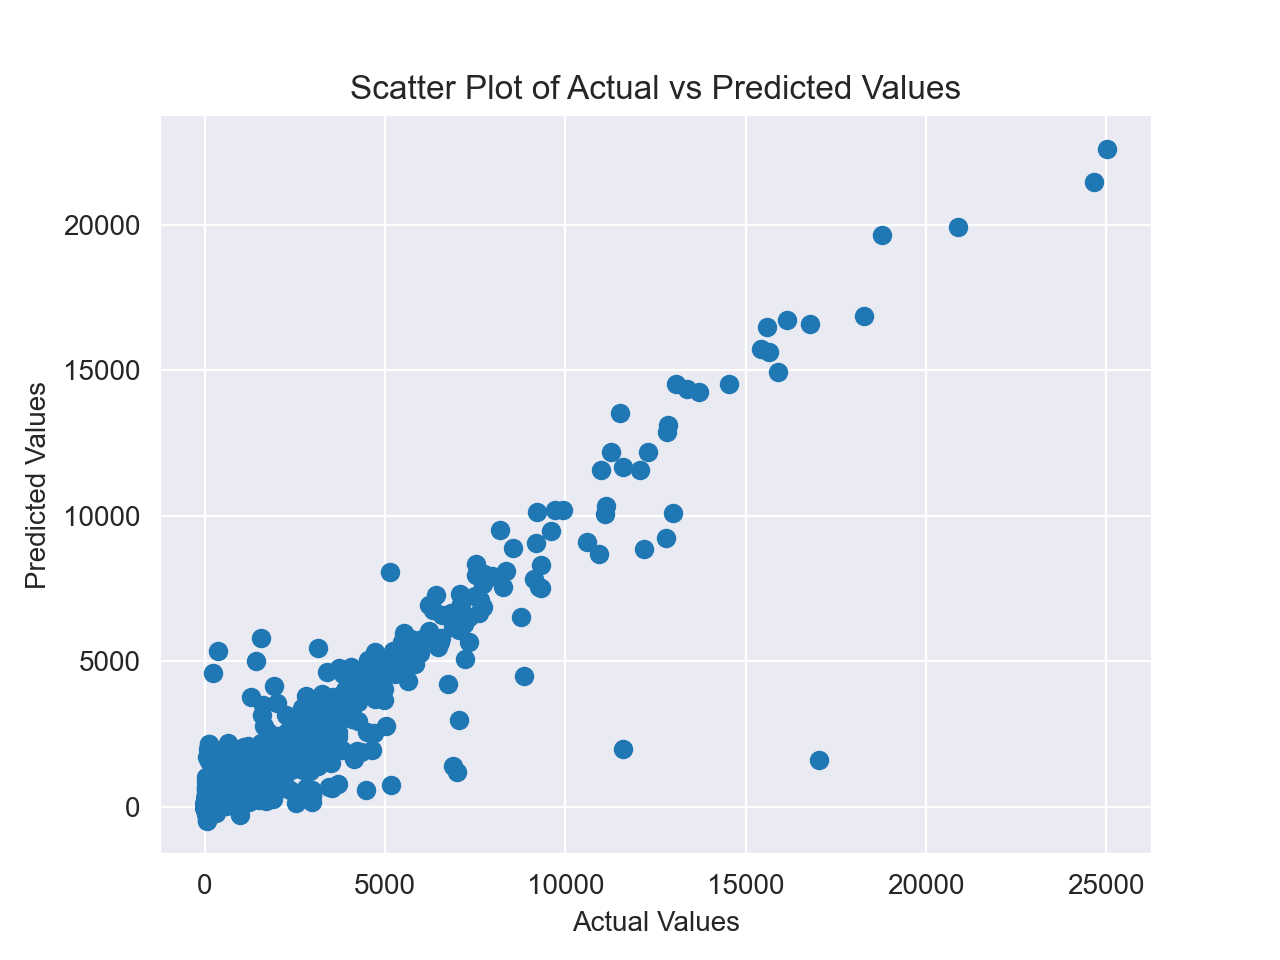

In [72]:
#Let's plot a dot plot of the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.show()

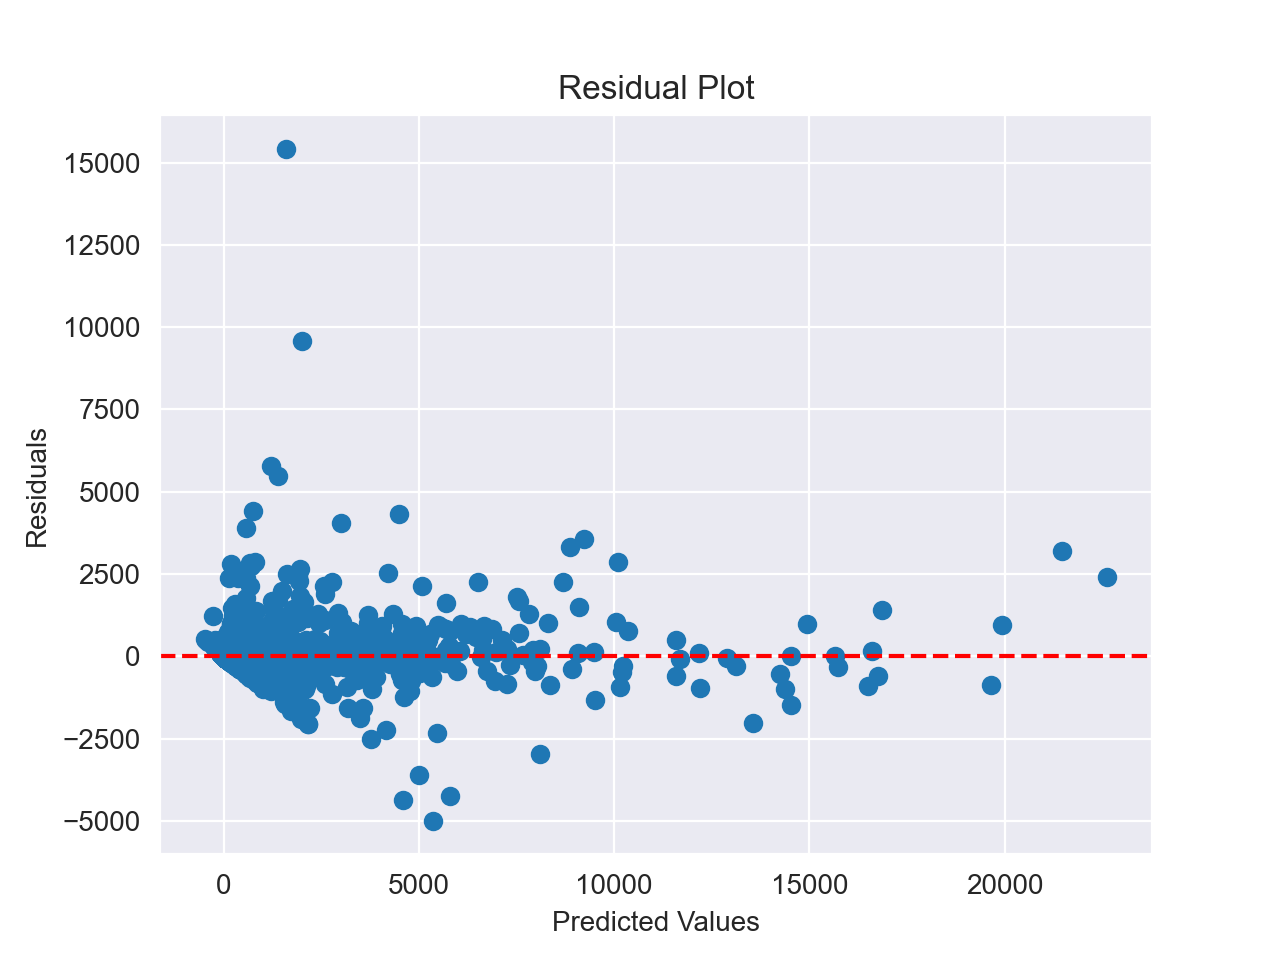

In [73]:
#Let's plot the residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [74]:
X_all = df1.drop(['Sales in units','date','Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
'Real price in units', 'Real price in volume', 'Rate price in units','Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'promotion','postal_code','Province', 'min temp', 'max temp', 'population', 'year',
       'price_diff_units','PACKAGING', 'VOLUME', 'UNITS','Channel', 'SEGMENT', 'MANUFACTURER', 'BRAND','Autonomus Community', 'is_promo', 'sales_surface_sqmeters'], axis=1) 

In [75]:
#Create DMatrix for all data
dall = xgb.DMatrix(X_all, enable_categorical=True)

In [76]:
#Make predictions using the XGBoost model
predictions_all = model.predict(dall)

In [77]:
#Add predictions_all into X
df1['Predictions Sales in units'] = predictions_all

In [78]:
#Create a new column with predictions sales unit if is_promo = 1 else sales in units
df1['Baseline Sales in units'] = np.where(df1['is_promo'] == "1", df1['Predictions Sales in units'], df1['Sales in units'])

In [79]:
#Create df_promo_year by aggregating sales units based on is_promo and date
df1_date_baseline = df1.groupby(['date'])['Baseline Sales in units'].sum().reset_index()
df1_date_sales = df1.groupby(['date'])['Sales in units'].sum().reset_index()
df1_date_baseline_sales = df1_date_baseline.merge(df1_date_sales, on='date', suffixes=('', '_total'))

#Plot df1_date_baseline_sales in a line chart
fig = px.line(df1_date_baseline_sales, x='date', y=df1_date_baseline_sales.columns[1:],
                title='Baseline Sales Units by Date',
                labels={'date': 'Date', 'value': 'Sales Units', 'variable': 'Promotion'},
                color_discrete_sequence=px.colors.qualitative.Plotly)

# Save the plot as an HTML file
pio.write_html(fig, 'images/Baseline_Sales_Units_by_Date.html', auto_open=False)

In [80]:
# Uncomment if a checkpoint is needed
# #Export to csv df1_date_baseline_sales
# df1_date_baseline_sales.to_csv('data_checkpoints/df1_date_baseline_sales.csv', index=False)

In [81]:
#Create a column with the difference between sales in units and baseline sales in units if is_promo is 1 otherwise sale in units
df1['Sales Uplift'] = np.where(df1['is_promo'] == "1", df1['Sales in units'] - df1['Baseline Sales in units'], 0)

In [82]:
df1['Sales Uplift'].sum() /df1['Baseline Sales in units'].sum()

0.20131114322782834

In [83]:
#Group df1 by promotion type and calculate the uplift
df1_promo_up = df1.groupby(['promotion'])['Sales Uplift'].sum().reset_index()
df1_promo_base = df1.groupby(['promotion'])['Baseline Sales in units'].sum().reset_index()
df1_promo = df1_promo_up.merge(df1_promo_base, on='promotion', suffixes=('', '_total'))
#Convert uplift to integer with coma separator
df1_promo['Sales Uplift'] = df1_promo['Sales Uplift'].astype(int)
df1_promo['Baseline Sales in units']=df1_promo['Baseline Sales in units'].astype(int)
#Calculate the uplift % by promotiion type
df1_promo['Baseline Sales in units %'] = df1_promo['Sales Uplift']/df1_promo['Baseline Sales in units']
df1_promo['Baseline Sales in units %'] = df1_promo['Baseline Sales in units %'].map("{:.2%}".format)
#Sort from higest to lowest
df1_promo = df1_promo.sort_values(by=['Sales Uplift'], ascending=False)
df1_promo

promotion  Sales Uplift  Baseline Sales in units  \
1       Promo descuento      26473936                 85143659   
4         Promo folleto      13469677                 37398127   
6     Promo multicompra       7994707                 13651875   
0        Promo cabecera       6802131                 25368411   
2       Promo expositor       5471704                 20968584   
5            Promo isla        519270                  2214982   
3  Promo extra cantidad        -49147                   454116   
7          Promo regalo        -82010                   771927   

  Baseline Sales in units %  
1                    31.09%  
4                    36.02%  
6                    58.56%  
0                    26.81%  
2                    26.09%  
5                    23.44%  
3                   -10.82%  
7                   -10.62%

Now, we will analyze how incremental sales are evolving through time, based on the different promotion types.

In [84]:
#Create a df for imcremental sales by date and promotion type
df1_date_type = df1.groupby(['date','promotion'])['Sales Uplift'].sum().reset_index()

#Barplot by date and promotion
fig = px.area(df1_date_type, x='date', y='Sales Uplift', color='promotion',
                title='Sales Uplift by Date and Promotion',
                labels={'date': 'Date', 'value': 'Sales Units', 'variable': 'Promotion'},
                color_discrete_sequence=px.colors.qualitative.Plotly)

# Save the plot as an HTML file
pio.write_html(fig, 'images/Sales_Uplift_by_Date_and_Promotion.html', auto_open=False)

In [85]:
#Create column incremental sales in Value (€)
df1['Incremental Sales in Value (€)'] = df1['Sales Uplift'] * df1['Real price in units']

In [86]:
#Create df_promo_year by aggregating sales units based on is_promo and date
df1_date_Incremental_Value = df1.groupby(['date'])['Incremental Sales in Value (€)'].sum().reset_index()

#plot in a line chart
fig = px.line(df1_date_Incremental_Value , x='date', y='Incremental Sales in Value (€)',
                title='Incremental Sales in Value (€) by Date',
                labels={'date': 'Date', 'value': 'Sales Units', 'variable': 'Promotion'},
                color_discrete_sequence=px.colors.qualitative.Plotly)
# Save the plot as an HTML file
pio.write_html(fig, 'images/Incremental_Sales_in_Value_by_Date.html', auto_open=False)

In [87]:
#Add a column to df1 with baseline sales in value    
df1['Baseline Sales in Value (€)'] = df1['Baseline Sales in units'] * df1['Real price in units']
#Sum of baseline in value (€)
df1['Baseline Sales in Value (€)'].sum()

437494210.41701835

In [88]:
#Sum of sales in value (€)
df1['Sales in value (€)'].sum()

331875178.72

In [89]:
df1['Incremental Sales in Value (€)'].sum()/df1['Sales in value (€)'].sum()

-0.31854191215731176

In [90]:
#Create a df with baseline sales in value, incremental sales in value and sales in value
df1_date_Incremental_Value = df1.groupby(['date'])['Incremental Sales in Value (€)'].sum().reset_index()
df1_date_Baseline_Value = df1.groupby(['date'])['Baseline Sales in Value (€)'].sum().reset_index()
df1_date_Sales_Value = df1.groupby(['date'])['Sales in value (€)'].sum().reset_index()
df1_date_Incremental_Value = df1_date_Incremental_Value.merge(df1_date_Baseline_Value, on='date', suffixes=('', '_total'))
df1_date_Incremental_Value = df1_date_Incremental_Value.merge(df1_date_Sales_Value, on='date', suffixes=('', '_total'))

In [91]:
#Plotting the bar chart for sales in value and line charts for incremental sales and baseline sales
fig = px.area(df1_date_Incremental_Value, x='date', y='Sales in value (€)', title='Impact on Baseline Sales Value of Incremental Volumes Expected from Promotions')
fig.add_bar(x=df1_date_Incremental_Value['date'], y=df1_date_Incremental_Value['Incremental Sales in Value (€)'], name='Incremental Sales in Value (€)')
fig.add_bar(x=df1_date_Incremental_Value['date'], y=df1_date_Incremental_Value['Baseline Sales in Value (€)'], name='Baseline Sales in Value (€)')

#Update the layout
fig.update_layout(
    yaxis=dict(title='Sales in Value (€)'),
    xaxis=dict(title='Date')
)

# Save the plot as an HTML file
pio.write_html(fig, 'images/Impact on Baseline Sales Value of Incremental Volumes Expected from Promotions.html', auto_open=False)

In [92]:
#Create df_promo_year by aggregating sales units based on is_promo and date
df1_date_promo_IV = df1.groupby(['date', 'promotion'])['Incremental Sales in Value (€)'].sum().reset_index()
                          
#Plotting the stacked bar chart for incremental sales by date and promotion
fig = px.bar(df1_date_promo_IV, x='date', y='Incremental Sales in Value (€)', color='promotion',
             title='Incremental Sales in Value (€) by Date',
             labels={'date': 'Date', 'value': 'Sales Units', 'variable': 'Promotion'},
             color_discrete_sequence=px.colors.qualitative.Plotly)

#Update the layout
fig.update_layout(barmode='stack', yaxis=dict(title='Sales Units'), xaxis=dict(title='Date'))

# Save the plot as an HTML file
pio.write_html(fig, 'images/Incremental Sales in Value_promotype.html', auto_open=False)

In [93]:
#Groupy df1_date_promo_Incremental_Value by promotion and calculate the sum
dfX= df1.groupby(['promotion'])['Incremental Sales in Value (€)'].sum().reset_index()
dfY = df1.groupby(['promotion'])['Sales in value (€)'].sum().reset_index()
#Merge both data sets above
dfXY= dfX.merge(dfY, on='promotion', suffixes=('', '_total'))
#Calculate the % of incremental sales in value by promotion
dfXY['Incremental Sales in Value (€) %'] = dfXY['Incremental Sales in Value (€)']/dfXY['Sales in value (€)']
dfXY['Incremental Sales in Value (€) %'] = dfXY['Incremental Sales in Value (€) %'].map("{:.2%}".format)


# <span style="color: purple">**4. Promotion Driver Analysis**</span> <a class="anchor" id="section_4"></a>

Once we have the ability to measure incremental unit sales and calculate ROIs from past promotion events, it becomes natural to **examine why certain promotions were successful while others did not yield favorable ROIs.** To understand the primary reasons behind the varying profitability of different promotion events, **a driver analysis (also known as DNA) is employed**. This analysis breaks down the incremental unit sales and profits into their contributing factors, providing insights into why certain types of promotions are more profitable than others. Several key drivers can influence promotion effectiveness, including:

- **External factors:** These encompass seasonality, holidays, trends, weather conditions, significant external events, store locations, demographics of the store's surroundings, and the level of competition in the vicinity.

- **Own promotion factors**: This category involves analyzing the types of promotions employed (e.g., feature promotions, display promotions, coupons), the specific promotion tactics used (e.g., Buy One Get One Free, simple price discounts, Must Buy 2), the extent of price cuts (e.g., 5% off, 15% off), and whether other products within the product portfolio were simultaneously promoted.

- **Competitor factors**: The promotion events carried out by competitors are considered in this driver analysis, as they can impact the success of a promotion.

- **Cost factors**: This includes examining raw material costs, costs associated with executing the promotion, and any vendor funding provided (for retailers).

We are going to focus on the **first 2 factors**, since we do not have access to the other drivers.

In [94]:
#We start by creating a copy to work with
df2 = df1.copy()

## <span style="color: purple">4.1. Feature engineering for identifying promotion drivers</span> <a class="anchor" id="section_4_1"></a>

In this first section we will create new features that can be drivers of the promotion success or failure. We will create the following features:
- Discount
- Simultaneous Promotions
- Promotion Duration

### <span style="color: purple">4.1.1 Discount</span> <a class="anchor" id="section_4_1_1"></a>

In [95]:
#We start by adding a new column to df2 called Discount and fill it with the following logic: 1 minus real price divided by rate price
df2['Discount'] = 1 - (df2['Real price in units']/df2['Rate price in units'])

In [96]:
#We create a df with is_promo = 1 and discount column
df2_promo = df2[df2['is_promo'] == "1"][['promotion','Discount']]

#Create a boxplot
fig = px.box(df2_promo, x="promotion", y="Discount", color="promotion",
             hover_data=df2_promo.columns, title="Discount by Promotion Type",
             labels={"Discount": "Discount", "promotion": "Promotion Type"})

# Save the plot as an HTML file
pio.write_html(fig, 'images/Discount_by_Promotion_Type.html', auto_open=False)

### <span style="color: purple">4.1.2 Running more than 1 promotion at a time</span> <a class="anchor" id="section_4_1_2"></a>

In [97]:
#Create a df with is_promo = 1 and discount
df2_promo = df2[df2['is_promo'] == "1"][['promotion','Discount']]

In [98]:
#We group the promos by week and count them
count_active_promo = df2.groupby(['Store Code','Product Code','date'])['promotion'].count().reset_index(name='promo_running_same_time')
#Sort by store code and date
count_active_promo = count_active_promo.sort_values(by=['Store Code', 'Product Code','date'])

In [99]:
#Merge active_promo with df2
df2 = df2.merge(count_active_promo, on=['Store Code','Product Code','date'], how='left')

### <span style="color: purple">4.1.3 Duration of the Promotion</span> <a class="anchor" id="section_4_1_3"></a>

In [100]:
df_duration = pd.read_csv('Datasets/consecutive_promo.csv')

In [101]:
#Merge df_duration with df2
df2 = df2.merge(df_duration, on=['Store Code','Product Code','Week Code'], how='left')

In [102]:
#Drop from df2 prpromotion_x and promotion_y
df2 = df2.drop(['promotion_y', 'year', 'Season','Number of references'], axis=1)

In [103]:
#If column holiday is different from 0 then 1 else 0
df2['holiday'] = np.where(df2['holiday'] != 0, 1, 0)

In [104]:
#convert week code to object
df2['Week Code'] = df2['Week Code'].astype('category')
#convert store code to object
df2['Store Code'] = df2['Store Code'].astype('category')
#convert product code to object
df2['Product Code'] = df2['Product Code'].astype('category')
#convert channel_code to object
df2['channel_code'] = df2['channel_code'].astype('category')
#convert province code  to object
df2['province code'] = df2['province code'].astype('category')
#convert postal_codeto object
df2['postal_code'] = df2['postal_code'].astype('category')
#convert holiday to category
df2['holiday'] = df2['holiday'].astype('category')
#convert is_promo to category
df2['is_promo'] = df2['is_promo'].astype('category')
#convert is_promo to category
df2['promo_running_same_time'] = df2['promo_running_same_time'].astype('category')


In [105]:
#Multiply liters/person by 100.000
df2['liters/person']=df2['liters/person']*100000

#Binarize df1['liters/person'] into 10 categories
df2['liters/person'] = pd.qcut(df2['liters/person'], q=10, precision=0)

In [106]:
#Select columns of 'object' data type
object_cols = df2.select_dtypes(include='object').columns

#Convert selected columns to 'category' data type
df2[object_cols] = df2[object_cols].astype('category')

## <span style="color: purple">4.2. Correlation Analysis</span> <a class="anchor" id="section_4_2"></a>

In the following sections we will perform a correlation analysis among the variables that we have with the main goal of understanding the variables that are more correlated or that can be impacting our sales uplift the most, which is the key variable that we have to observe in order to be able to understand the success of a promotion.

In [107]:
#Split data set in numerical and categorical
df2_num = df2.select_dtypes(include=['float64','float32', 'int64'])
df2_cat = df2.select_dtypes(include=['category'])

In [108]:
#We calculate correlation of numerical variables against Sales Uplift
df2_num.corr()[['Sales Uplift']].sort_values('Sales Uplift')

Sales Uplift
Baseline Sales in Value (€)        -0.139888
Rate price in units                -0.046975
Real price in units                -0.046272
Real price in volume               -0.044530
Rate price in volume               -0.044530
UNITS                              -0.043434
precipitation                      -0.004283
Year                               -0.002971
Quarter                            -0.002426
Month                              -0.001129
VOLUME                              0.000471
population                          0.007263
min temp                            0.007952
mean temp                           0.008936
max temp                            0.009442
price_diff_units                    0.020996
Duration                            0.023349
sales_surface_sqmeters              0.034539
Discount                            0.064544
Incremental Sales in Value (€)      0.319428
Sales in value (€)                  0.457630
Baseline Sales in units             0.474405
Predictions Sales in units          0.475009
Sales in volume (Lt)                0.674639
Sales in units                      0.899935
Sales Uplift                        1.000000

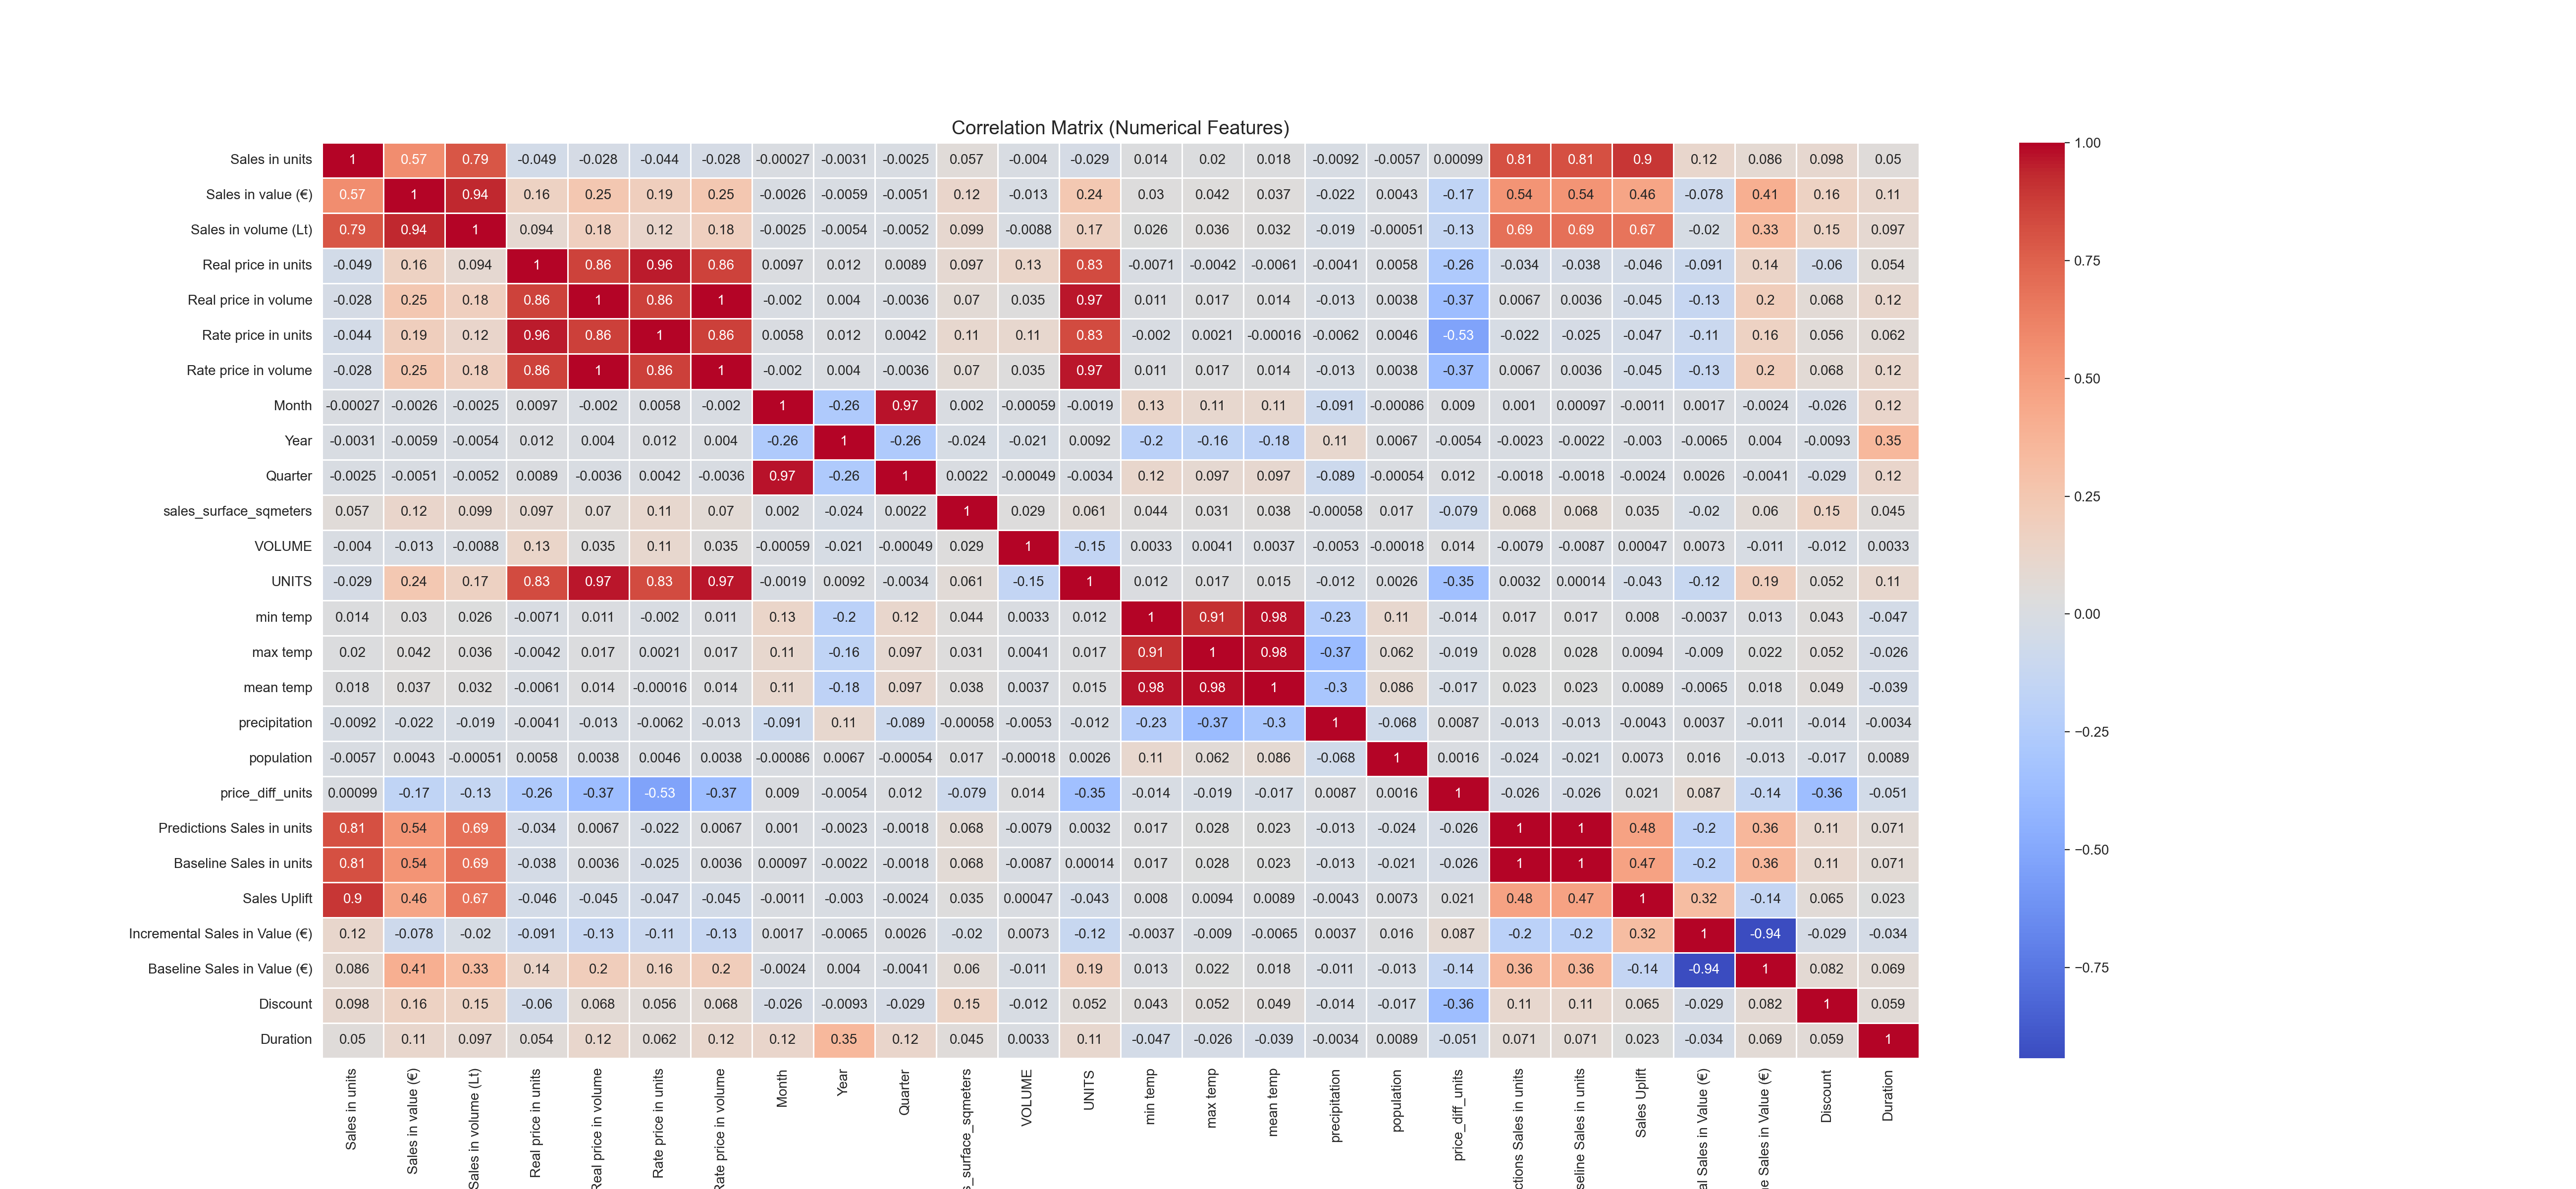

In [109]:
#Let's plot a complete correlation matrix for numerical variables
sns.set_style('dark')

plt.figure(figsize=(26,12))
sns.heatmap(df2_num.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Numerical Features)', fontsize=14)
plt.show()

In [110]:
#We will perform a chi-square test for each pair of categorical variables and calculate Cramer's V, with the aim of statistically validating the correlation between categorical variables

#Perform chi-square test and calculate Cramer's V for each pair of categorical variables
corr_matrix = np.zeros((len(df2_cat.columns), len(df2_cat.columns)))

for i, col1 in enumerate(df2_cat.columns):
    for j, col2 in enumerate(df2_cat.columns):
        if i != j:
            contingency_table = pd.crosstab(df2_cat[col1], df2_cat[col2])
            chi2, _, _, _ = stats.chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            phi2 = chi2 / n
            r, k = contingency_table.shape
            phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
            r_corr = r - ((r - 1) ** 2) / (n - 1)
            k_corr = k - ((k - 1) ** 2) / (n - 1)
            corr_matrix[i, j] = np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

#Create a correlation matrix DataFrame
corr_df = pd.DataFrame(corr_matrix, index=df2_cat.columns, columns=df2_cat.columns)

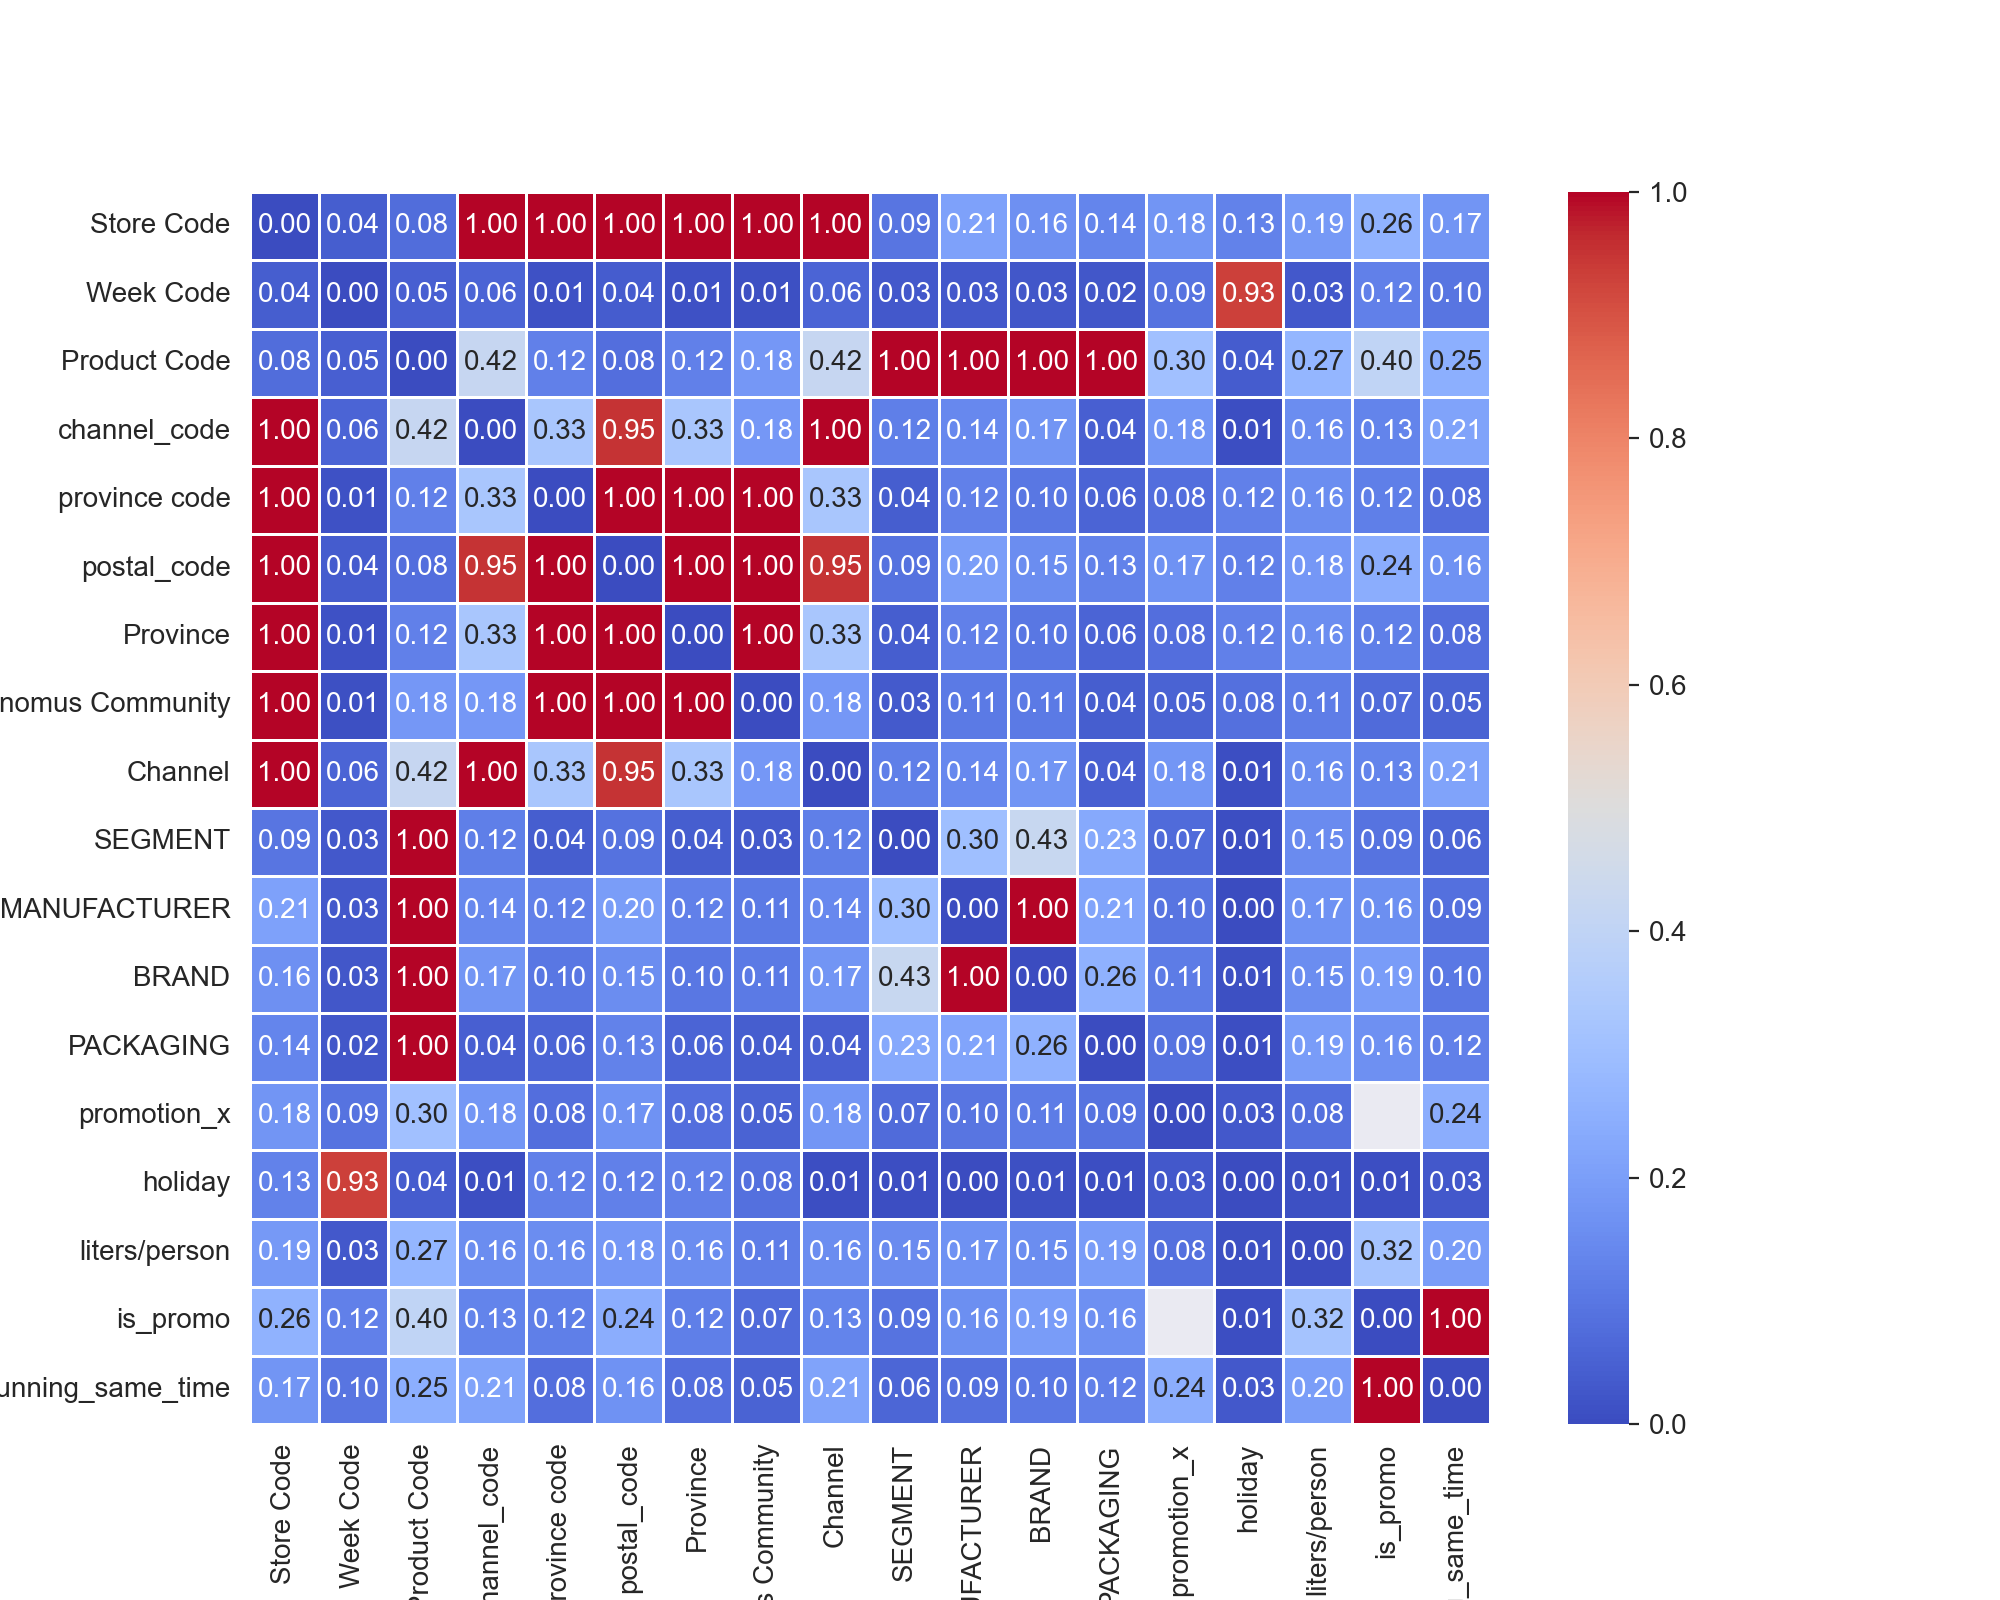

In [111]:
#Plot the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white', fmt='.2f')
plt.show()

In [112]:
df2_final = df2.drop(['Sales in units','Incremental Sales in Value (€)','Store Code','Product Code','channel_code','MANUFACTURER','Autonomus Community','postal_code','Province','Baseline Sales in Value (€)','Baseline Sales in units','Predictions Sales in units','price_diff_units','population','min temp','max temp','UNITS','Quarter','Year','Month','Rate price in volume','Rate price in units','Real price in volume','Sales in volume (Lt)','Sales in value (€)','Real price in units', 'is_promo'], axis=1)

In [113]:
#Split between categorical and numerical
df2_final_num = df2_final.select_dtypes(include=['float64','float32', 'int64'])
df2_final_cat = df2_final.select_dtypes(include=['category'])

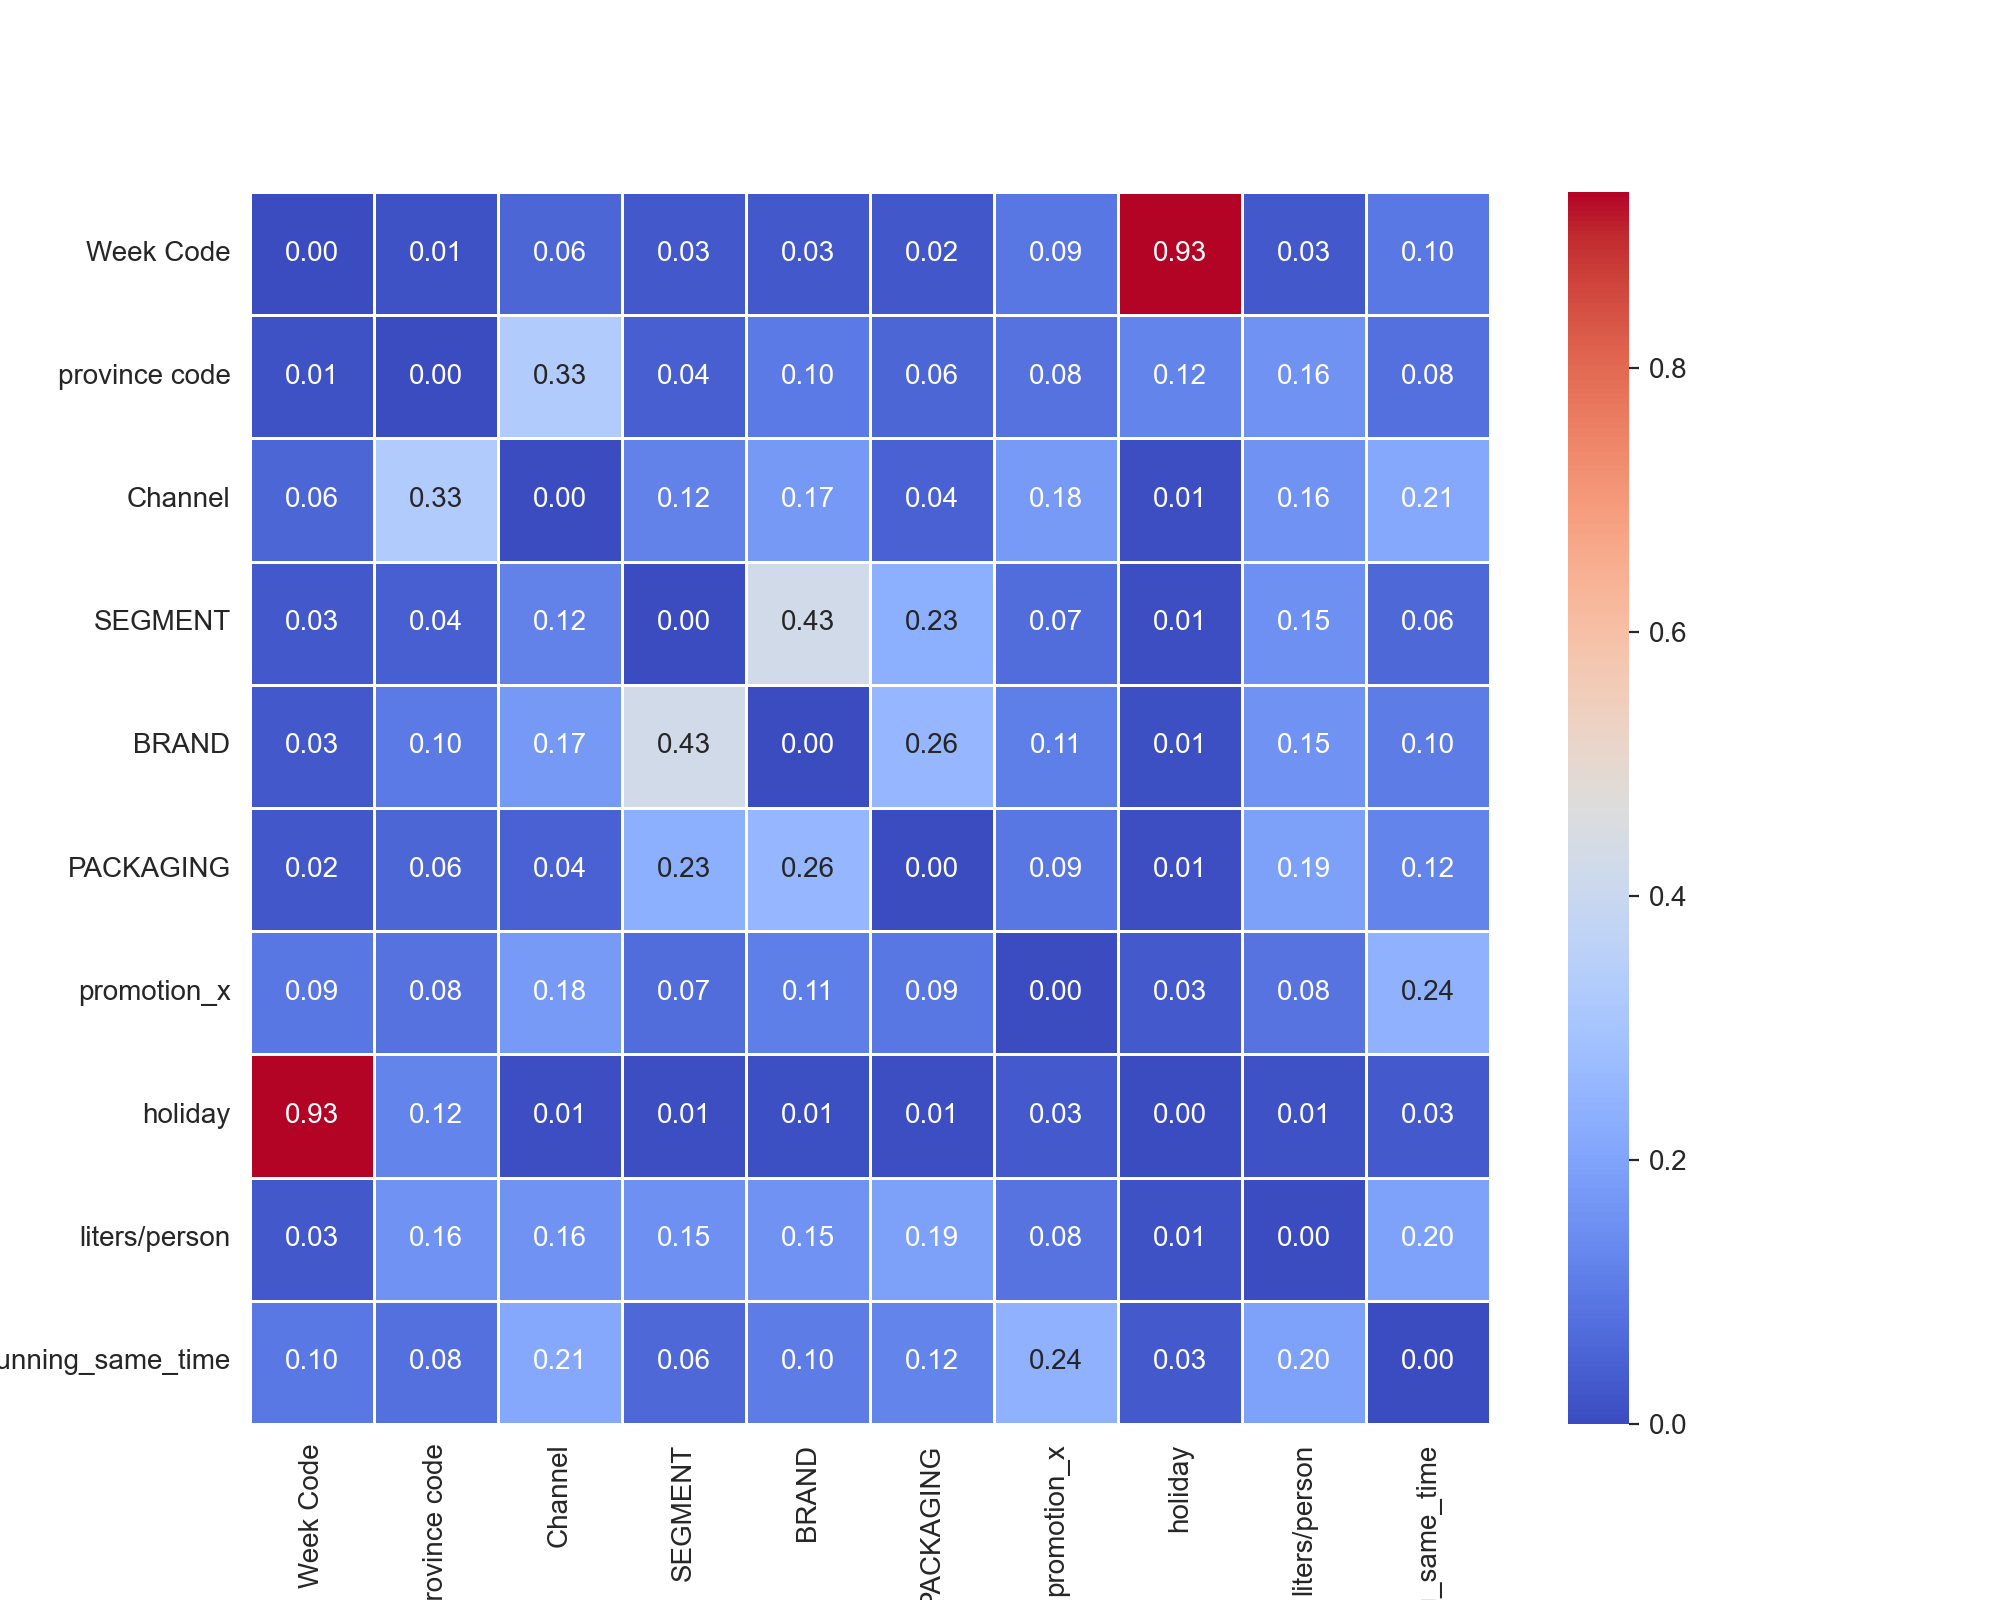

In [114]:
#Calculate correlation matrix for categorical variables
cat_corr_matrix = np.zeros((len(df2_final_cat.columns), len(df2_final_cat.columns)))

for i, col1 in enumerate(df2_final_cat.columns):
    for j, col2 in enumerate(df2_final_cat.columns):
        if i != j:
            contingency_table = pd.crosstab(df2_final_cat[col1], df2_final_cat[col2])
            chi2, _, _, _ = stats.chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            phi2 = chi2 / n
            r, k = contingency_table.shape
            phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
            r_corr = r - ((r - 1) ** 2) / (n - 1)
            k_corr = k - ((k - 1) ** 2) / (n - 1)
            cat_corr_matrix[i, j] = np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

cat_corr_df = pd.DataFrame(cat_corr_matrix, index=df2_final_cat.columns, columns=df2_final_cat.columns)

plt.figure(figsize=(10, 8))
sns.heatmap(cat_corr_df, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white', fmt='.2f')
plt.show()

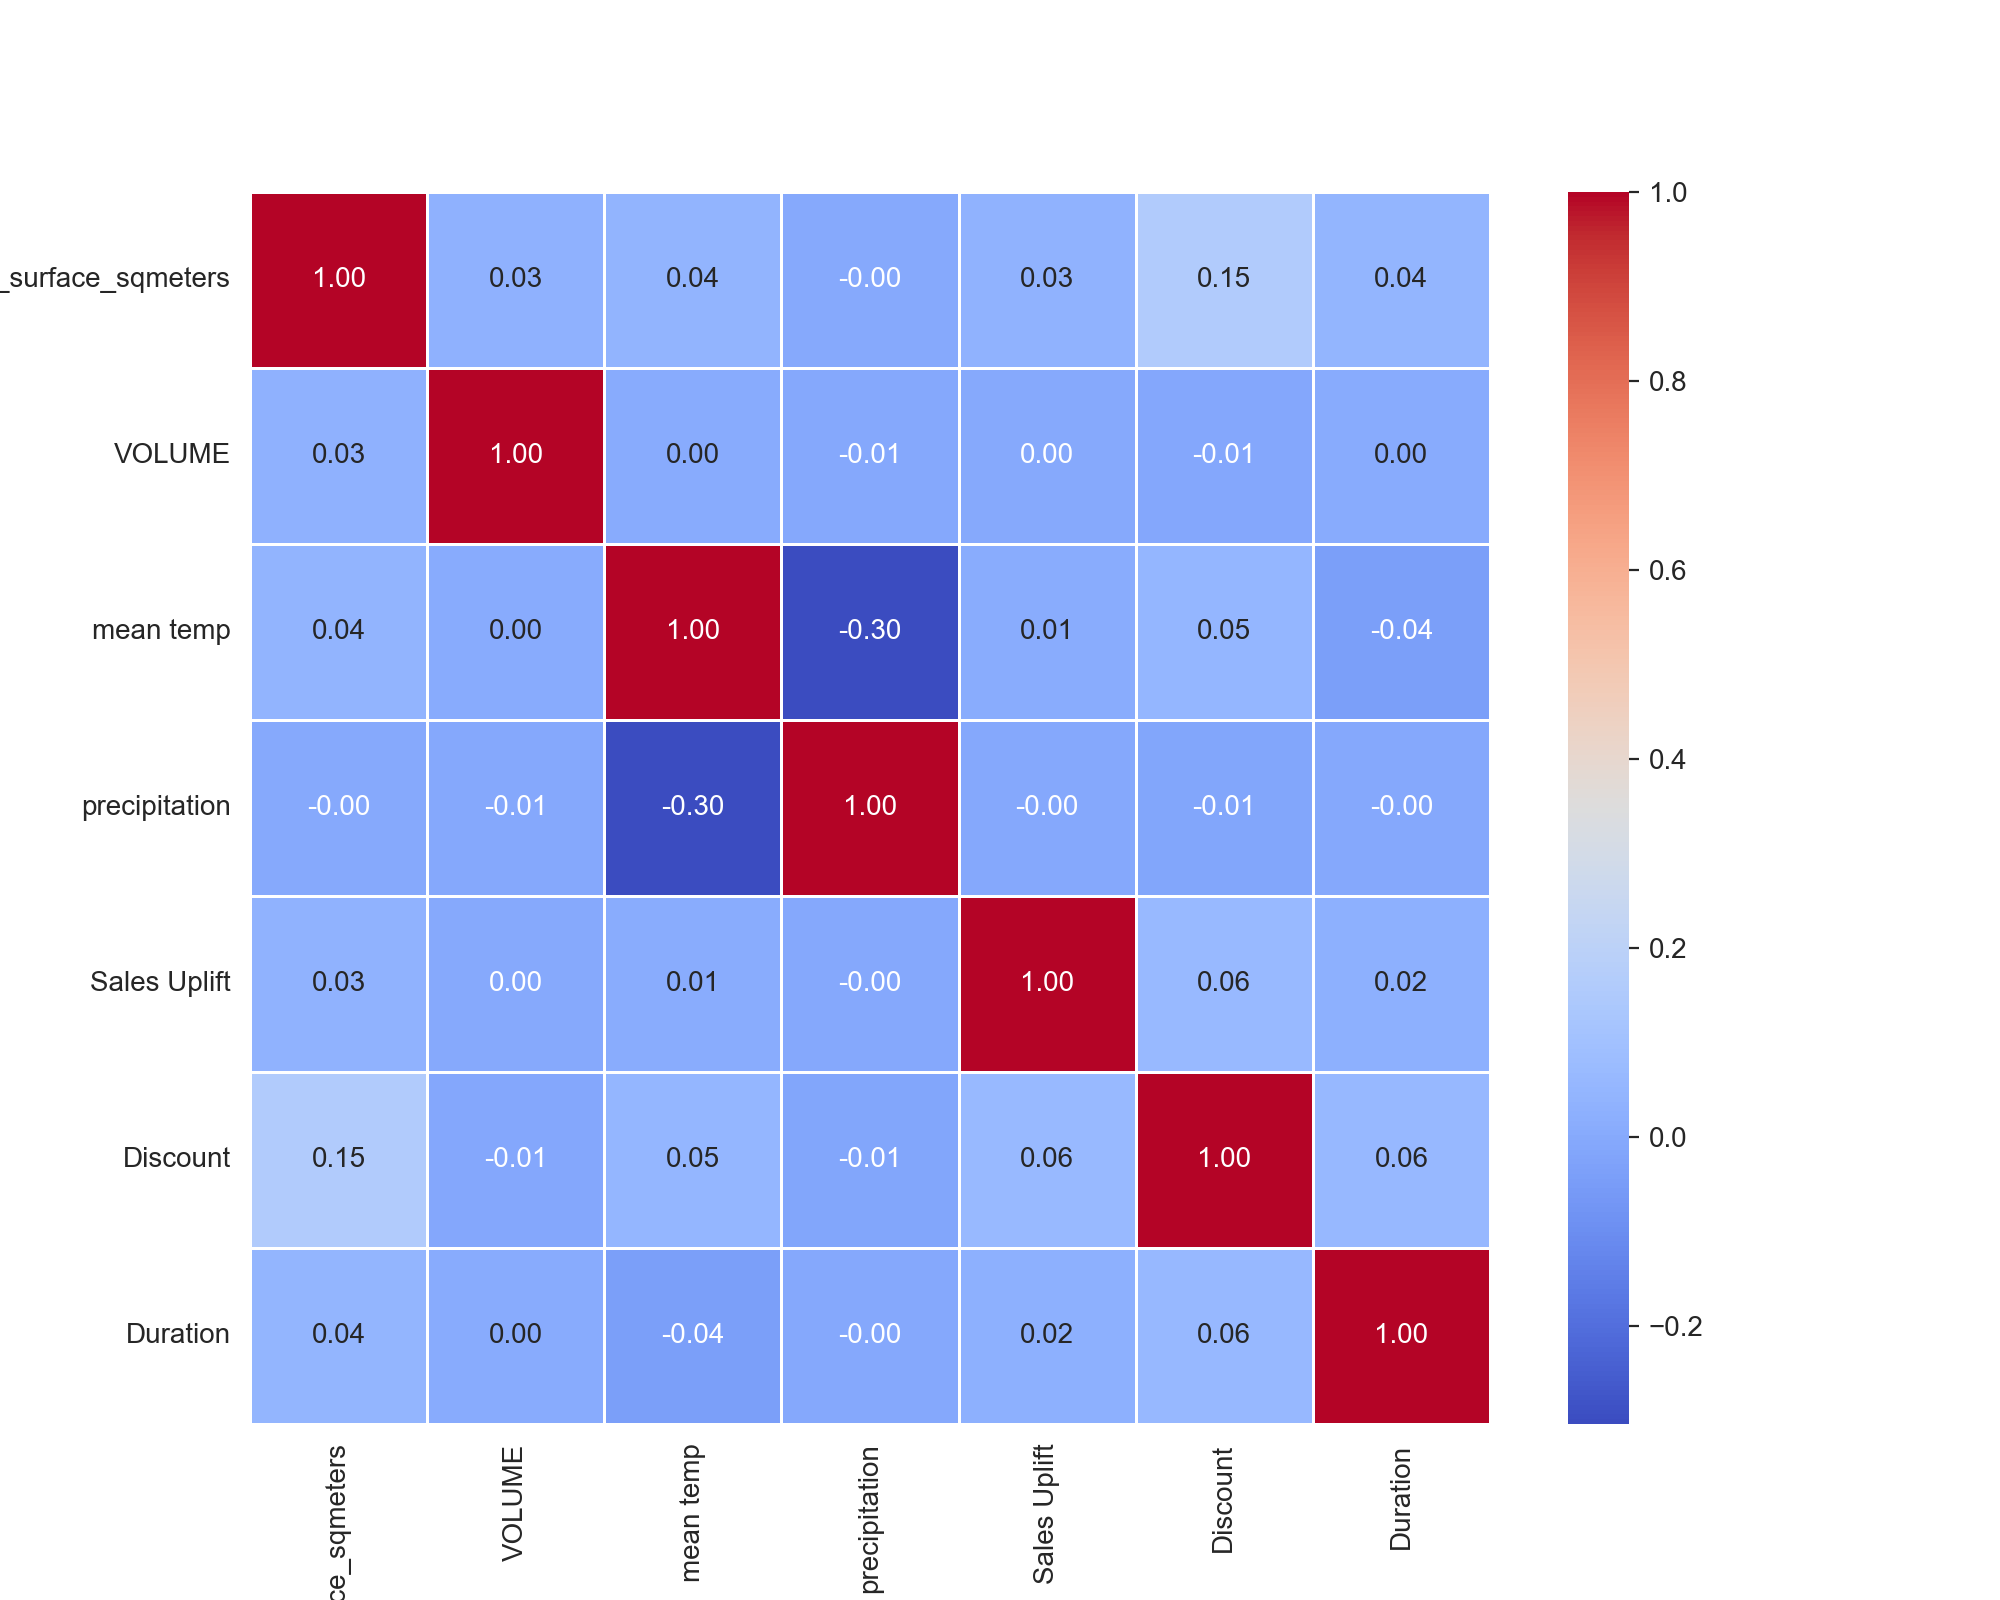

In [115]:
#Calculate correlation matrix for numerical variables
num_corr_df =df2_final_num.select_dtypes(include='number').corr()

#Plot the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(num_corr_df, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white', fmt='.2f')
plt.show()

## <span style="color: purple">4.3. XGBoost for identifying the variables causing sales uplift</span> <a class="anchor" id="section_4_3"></a>

At this point we will apply a XGBoost model to identify the variables that are causing sales uplift. We will use the df configured in the previous section.

In [116]:
#Split the data into training and testing sets
X1 = df2_final.drop(['Sales Uplift','date'], axis=1)  # Features
y1 = df2_final['Sales Uplift']  # Target variable

In [117]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [118]:
#Create DMatrix and set enable_categorical=True
df1train = xgb.DMatrix(X1_train, label=y1_train, enable_categorical=True)

In [119]:
#Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 25,
    'learning_rate': 0.6,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 1.5,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'min_child_weight': 1
}


In [120]:
#Create DMatrix and set enable_categorical=True
model1 = xgb.train(params, df1train)

In [121]:
#Create DMatrix for test
df1test = xgb.DMatrix(X1_test, enable_categorical=True)

In [122]:
#Make predictions on the test set
y1_pred = model1.predict(df1test)

#Calculate the mean squared error (MSE)
mse1 = mean_squared_error(y1_test, y1_pred)
print("Mean Squared Error (MSE):", mse1)

# Calculate R-squared value
r2 = r2_score(y1_test, y1_pred)
print("R-squared: {:.4f}".format(r2))

Mean Squared Error (MSE): 5370.877671877659
R-squared: 0.9895


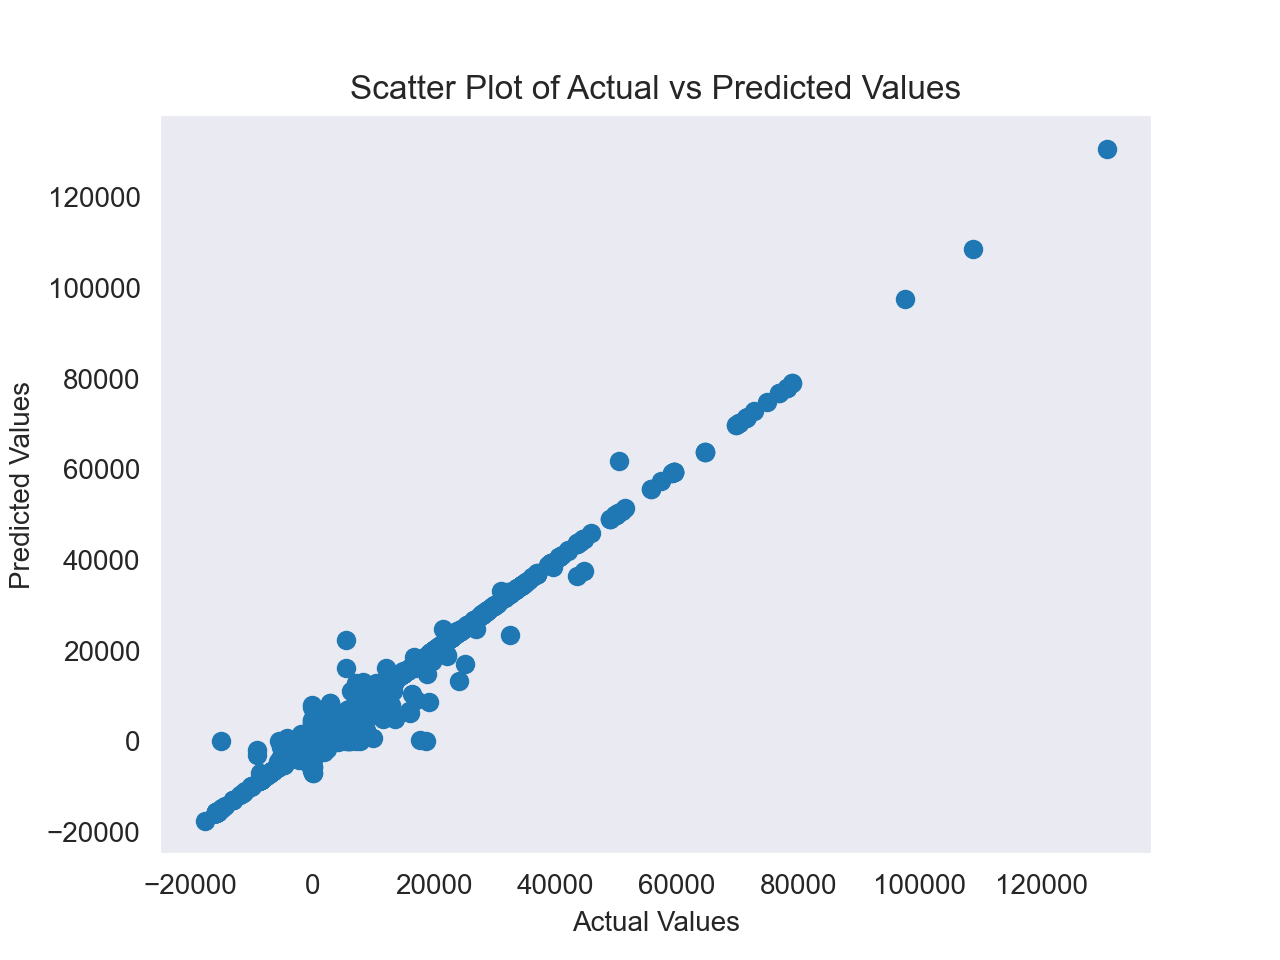

In [123]:
#Plot the actual vs predicted values
plt.scatter(y1_test, y1_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.show()

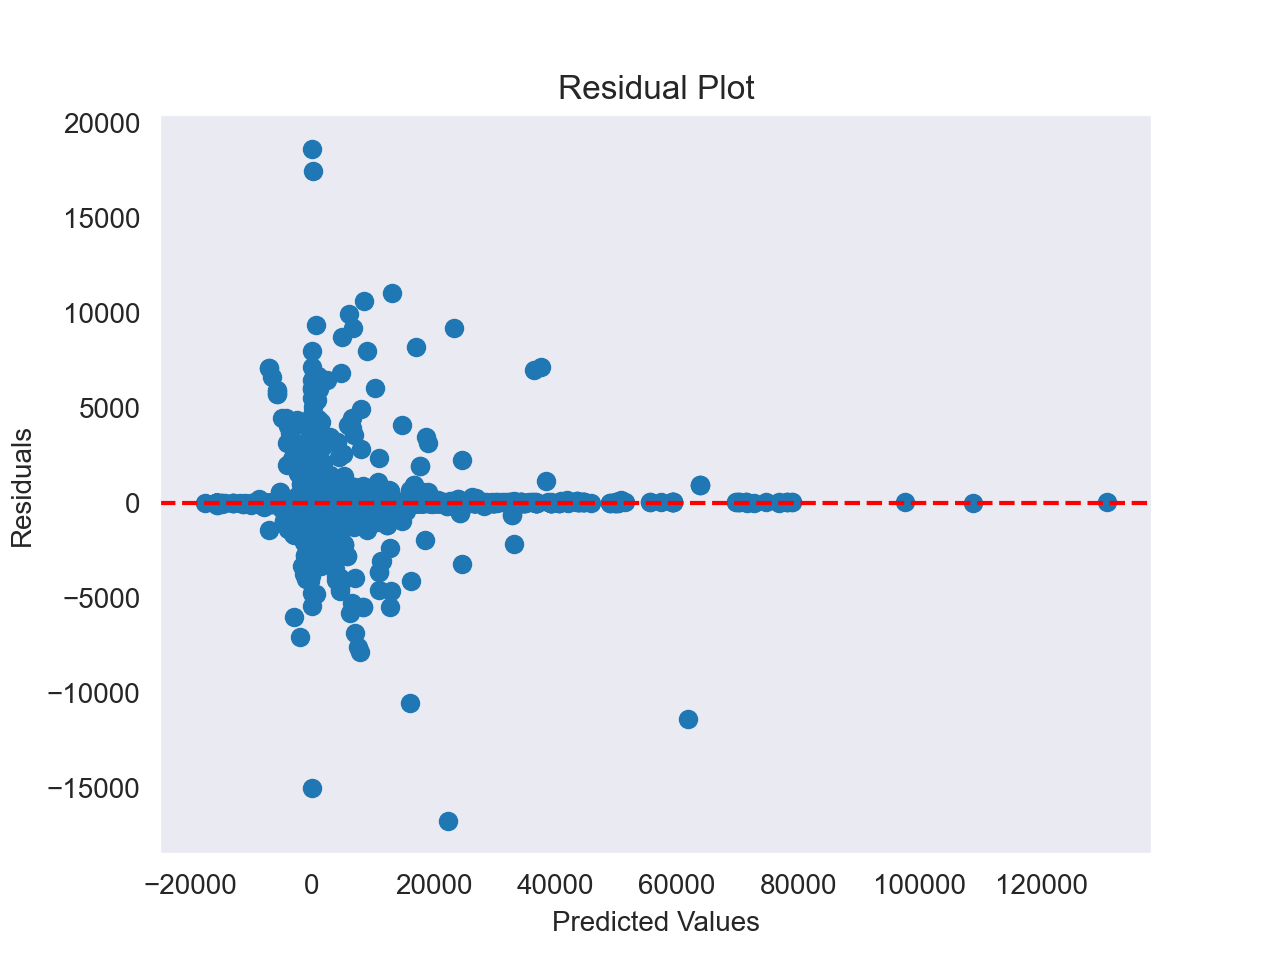

In [124]:
#We plot residuals
residuals1 = y1_test - y1_pred
plt.scatter(y1_pred, residuals1)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [125]:
#Get feature importances
importances = model1.get_score(importance_type="gain")

#Convert the importances dictionary to a DataFrame
importance_df = pd.DataFrame({'Feature': list(importances.keys()), 'Importance': list(importances.values())})

#Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)

#Create a vertical bar plot of feature importances using Plotly
fig = go.Figure(data=[go.Bar(x=importance_df['Importance'], y=importance_df['Feature'], orientation='h')])

fig.update_layout(
    title='Feature Importances',
    xaxis_title='Importance',
    yaxis_title='Feature',
    height=600, 
    width=800  
)
# Save the plot as an HTML file
pio.write_html(fig, 'images/feature_importance.html', auto_open=False)

## <span style="color: purple">**5. Deep-dive of the first Key Drivers of sales uplift**</span> <a class="anchor" id="section_5"></a>

In the next section we will perform a deep-dive analysis of the impact of each of the identified key drivers of sales uplift. 

## <span style="color: purple">5.1. Segment</span> <a class="anchor" id="section_5_1"></a>

In [126]:
#Create a DataFrame to analyze the incremental sales by segment and promotion
df2_segment_X = df2.groupby(['SEGMENT'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_segment_Y = df2.groupby(['SEGMENT'])['Sales in value (€)'].sum().reset_index()
df2_segment_Z = df2.groupby(['SEGMENT'])['Sales Uplift'].sum().reset_index()

#Merge both data sets
df2_segmentXY = df2_segment_X.merge(df2_segment_Y, on='SEGMENT', suffixes=('', '_total'))
df2_segment = pd.merge(df2_segmentXY, df2_segment_Z, on='SEGMENT')

#Calculate the percentage of incremental sales in value by promotion
df2_segment['Incremental Sales in Value (€) %'] = (df2_segment['Incremental Sales in Value (€)'] / df2_segment['Sales in value (€)'])
#Sort by Incremental Sales in Value (€) %
df2_segment = df2_segment.sort_values(by='Incremental Sales in Value (€) %', ascending=False)

df2_segment

SEGMENT  Incremental Sales in Value (€)  Sales in value (€)  \
6   IMPORT SPECIAL                    2.234355e+06        1.898942e+07   
2          CELIACS                    5.426591e+04        1.375206e+06   
0         ARTISANS                    5.188703e+04        1.787933e+06   
1            BLACK                   -6.306331e+04        3.448659e+06   
8  WITHOUT ALCOHOL                   -1.736227e+06        1.196584e+07   
3            EXTRA                   -5.123030e+06        3.075736e+07   
4        FLAVOURED                   -5.000394e+06        2.333978e+07   
9     ZERO ALCOHOL                   -4.236850e+06        1.766448e+07   
5   IMPORT PREMIUM                   -4.349464e+07        1.010173e+08   
7         NATIONAL                   -1.685456e+08        3.550865e+08   

   Sales Uplift  Incremental Sales in Value (€) %  
6  4.341218e+06                          0.117663  
2  1.357441e+05                          0.039460  
0  6.001622e+04                          0.029021  
1  2.097180e+05                         -0.018286  
8  2.273061e+06                         -0.145099  
3  4.675528e+06                         -0.166563  
4  7.131808e+06                         -0.214243  
9  2.111981e+06                         -0.239851  
5  1.093199e+08                         -0.430566  
7  2.914858e+07                         -0.474661

In [127]:
#Plot the incremental sales in value by SEGMENT sorting by incremental Incremental Sales in Value (€) %
fig = px.bar(df2_segment, x='SEGMENT', y='Incremental Sales in Value (€) %', color='SEGMENT', text='Incremental Sales in Value (€) %',
             title='Incremental Sales in Value by SEGMENT', color_continuous_scale=px.colors.qualitative.Plotly)

#Add percentage labels to the bars
fig.update_traces(textposition='auto', texttemplate='%{text:.2%}')

#Set the y-axis label with percentage format
fig.update_yaxes(title_text='Incremental Sales in Value (€) %')

# Save the plot as an HTML file
pio.write_html(fig, 'images/incrementa_sales_value_segment.html', auto_open=False)

In [128]:
#Create df_promo_year by aggregating sales units based on is_promo and date
df2_date_segment = df2.groupby(['date', 'SEGMENT'])['Incremental Sales in Value (€)'].sum().reset_index()
                          
#Plotting the stacked bar chart for incremental sales by date and promotion
fig = px.bar(df2_date_segment, x='date', y='Incremental Sales in Value (€)', color='SEGMENT',
             title='Incremental Sales in Value (€) by Date',
             labels={'date': 'Date', 'value': 'Incremental Sales in Value', 'variable': 'Promotion'},
             color_discrete_sequence=px.colors.qualitative.Plotly)

#Update the layout
fig.update_layout(barmode='stack', xaxis=dict(title='Date'))

# Save the plot as an HTML file
pio.write_html(fig, 'images/incrementa_sales_value_segment_date.html', auto_open=False)

## <span style="color: purple">5.2. Volume</span> <a class="anchor" id="section_5_2"></a>

In [129]:
#Change VOLUME from numerical to categorical
df2['VOLUME'] = df2['VOLUME'].astype('category')

#Create a DataFrame to analyze the incremental sales by segment and promotion
df2_volume_X = df2.groupby(['VOLUME'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_volume_Y = df2.groupby(['VOLUME'])['Sales in value (€)'].sum().reset_index()
df2_volume_Z = df2.groupby(['VOLUME'])['Sales Uplift'].sum().reset_index()

#Merge both data sets
df2_volumeXY = df2_volume_X.merge(df2_volume_Y, on='VOLUME', suffixes=('', '_total'))
df2_volume = pd.merge(df2_volumeXY, df2_volume_Z, on='VOLUME')

#Calculate the percentage of incremental sales in value by promotion
df2_volume['Incremental Sales in Value (€) %'] = (df2_volume['Incremental Sales in Value (€)'] / df2_volume['Sales in value (€)'])
#Sort by Incremental Sales in Value (€) %
df2_volume = df2_volume.sort_values(by='Incremental Sales in Value (€) %', ascending=False)

df2_volume

VOLUME  Incremental Sales in Value (€)  Sales in value (€)  Sales Uplift  \
14    500                    2.280771e+07        5.238288e+07  4.607147e+07   
16    568                    1.239900e+06        4.197156e+06  2.619858e+06   
5     300                    1.749738e+04        1.349146e+05  1.403969e+04   
18    660                    2.603036e+04        3.371533e+05  2.211761e+04   
21   1000                    6.446042e+05        1.317318e+07  1.145702e+06   
12    450                    2.223498e+03        6.206911e+04  1.746931e+03   
22   1100                    3.978745e+04        2.830287e+06  2.135866e+05   
13    473                    1.295202e+02        9.827500e+03  1.692334e+02   
26  20000                    0.000000e+00        8.547000e+02  0.000000e+00   
27  50000                    0.000000e+00        1.486080e+03  0.000000e+00   
17    650                   -7.206963e+03        2.492622e+05 -3.411100e+03   
15    550                   -7.506269e+02        2.508882e+04 -3.067837e+02   
7     350                   -4.176087e+02        1.009743e+04 -2.391416e+01   
11    440                   -4.446607e+04        7.350808e+05  3.578638e+04   
19    735                   -1.990209e+02        2.382800e+03 -4.194739e+01   
0     200                   -2.439945e+05        2.149008e+06 -4.788829e+04   
20    750                   -2.256774e+05        1.395657e+06 -2.655662e+04   
23   1500                   -1.274923e+04        6.846163e+04 -7.540449e+03   
24   2000                   -3.552530e+04        1.691810e+05 -5.662255e+03   
2     250                   -1.679803e+07        6.567825e+07 -2.760058e+06   
3     285                   -1.442363e+05        4.886391e+05 -4.089675e+04   
8     355                   -1.660870e+06        4.070703e+06  2.574856e+05   
6     330                   -2.172635e+08        3.984256e+08  1.140838e+08   
1     210                   -7.153438e+05        1.148973e+06 -1.751284e+05   
25   5000                   -4.585907e+05        6.529654e+05 -3.519135e+04   
9     375                   -1.300095e+07        1.701283e+07 -1.952265e+06   
4     299                   -5.020677e+03        4.832680e+03 -3.358045e+02   
10    377                   -1.964857e+04        1.565433e+04 -2.826794e+03   

    Incremental Sales in Value (€) %  
14                          0.435404  
16                          0.295414  
5                           0.129692  
18                          0.077206  
21                          0.048933  
12                          0.035823  
22                          0.014058  
13                          0.013179  
26                          0.000000  
27                          0.000000  
17                         -0.028913  
15                         -0.029919  
7                          -0.041358  
11                         -0.060491  
19                         -0.083524  
0                          -0.113538  
20                         -0.161700  
23                         -0.186224  
24                         -0.209984  
2                          -0.255762  
3                          -0.295180  
8                          -0.408006  
6                          -0.545305  
1                          -0.622594  
25                         -0.702320  
9                          -0.764185  
4                          -1.038901  
10                         -1.255152

In [130]:
#Plot the incremental sales in value by SEGMENT sorting by incremental Incremental Sales in Value (€) %
fig = px.bar(df2_volume, x='VOLUME', y='Incremental Sales in Value (€) %', color='VOLUME', text='Incremental Sales in Value (€) %',
             title='Incremental Sales in Value by VOLUME', color_continuous_scale=px.colors.qualitative.Plotly)

#Add percentage labels to the bars
fig.update_traces(textposition='auto', texttemplate='%{text:.2%}')

#Set the x-axis as categorical
fig.update_xaxes(type='category')

#Set the y-axis label with percentage format
fig.update_yaxes(title_text='Incremental Sales in Value (€) %')

# Save the plot as an HTML file
pio.write_html(fig, 'images/incrementa_sales_value_volumne.html', auto_open=False)

In [131]:
#Create df_promo_year by aggregating sales units based on is_promo and date
df2_date_segment = df2.groupby(['date', 'VOLUME'])['Incremental Sales in Value (€)'].sum().reset_index()
                          
#Plotting the stacked bar chart for incremental sales by date and promotion
fig = px.bar(df2_date_segment, x='date', y='Incremental Sales in Value (€)', color='VOLUME',
             title='Incremental Sales in Value (€) by Date',
             labels={'date': 'Date', 'value': 'Incremental Sales in Value', 'variable': 'Promotion'},
             color_discrete_sequence=px.colors.qualitative.Plotly)

#Update the layout
fig.update_layout(barmode='stack', xaxis=dict(title='Date'))

# Save the plot as an HTML file
pio.write_html(fig, 'images/incrementa_sales_value_volumne_date.html', auto_open=False)

## <span style="color: purple">5.3. Province</span> <a class="anchor" id="section_5_3"></a>

In [132]:
#Create a DataFrame to analyze the incremental sales by segment and promotion
df2_province_X = df2.groupby(['Province'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_province_Y = df2.groupby(['Province'])['Sales in value (€)'].sum().reset_index()
df2_province_Z = df2.groupby(['Province'])['Sales Uplift'].sum().reset_index()

#  both data sets
df2_provinceXY = df2_province_X.merge(df2_province_Y, on='Province', suffixes=('', '_total'))
df2_province = pd.merge(df2_provinceXY, df2_province_Z, on='Province')

#Calculate the percentage of incremental sales in value by promotion
df2_province['Incremental Sales in Value (€) %'] = (df2_province['Incremental Sales in Value (€)'] / df2_province['Sales in value (€)'])
#Sort by Incremental Sales in Value (€) %
df2_province = df2_province.sort_values(by='Incremental Sales in Value (€) %', ascending=False)

df2_province

Province  Incremental Sales in Value (€)  \
32                           Malaga                    3.339683e+06   
5      Area Metropolitana de Madrid                   -3.348993e+06   
20                          Granada                   -4.089509e+05   
4   Area Metropolitana de Barcelona                   -1.752667e+06   
31                           Madrid                   -1.468090e+05   
43                           Teruel                   -7.235323e+04   
26                        La Coruña                   -2.788620e+05   
49                         Zaragoza                   -1.727299e+06   
47                          Vizcaya                   -2.017818e+06   
10                        Barcelona                   -1.355626e+06   
18                           Cuenca                   -3.362746e+04   
2                          Alicante                   -4.927493e+06   
36                         Palencia                   -6.802655e+04   
33                           Murcia                   -2.149591e+06   
35                          Ourense                   -9.013468e+04   
15                        Castellon                   -1.933016e+06   
30                             Lugo                   -1.257678e+05   
13                            Cadiz                   -3.009189e+06   
28                             Leon                   -1.680832e+06   
40                          Sevilla                   -5.953864e+06   
0                             Alava                   -1.399343e+05   
48                           Zamora                   -4.985536e+04   
27                         La Rioja                   -4.016968e+05   
37                       Pontevedra                   -4.352359e+05   
19                           Girona                   -1.462878e+06   
3                           Almeria                   -7.618438e+05   
46                       Valladolid                   -4.344580e+06   
29                           Lleida                   -2.062130e+05   
21                      Guadalajara                   -1.058223e+06   
6                          Asturias                   -2.917364e+06   
17                          Cordoba                   -2.508078e+06   
14                        Cantabria                   -1.947157e+06   
24                           Huesca                   -6.914259e+05   
42                        Tarragona                   -6.362426e+06   
7                             Avila                   -1.598164e+05   
9                          Baleares                   -8.396783e+06   
44                           Toledo                   -7.354152e+05   
39                          Segovia                   -2.454623e+04   
25                             Jaen                   -2.843306e+06   
34                          Navarra                   -7.809138e+06   
8                           Badajoz                   -7.991281e+06   
38                        Salamanca                   -8.080202e+06   
45                         Valencia                   -2.486625e+07   
41                            Soria                   -7.426268e+05   
16                      Ciudad Real                   -4.583610e+06   
22                        Guipuzkoa                   -1.155153e+07   
23                           Huelva                   -2.151958e+06   
12                          Caceres                   -1.588975e+07   
1                          Albacete                   -3.909797e+07   
11                           Burgos                   -3.990695e+07   

    Sales in value (€)  Sales Uplift  Incremental Sales in Value (€) %  
32        2.454005e+07  9.023251e+06                          0.136091  
5         1.143807e+08  4.442544e+07                         -0.029279  
20        1.381606e+07  1.276715e+07                         -0.029600  
4         3.383542e+07  5.856175e+06                         -0.051800  
31        2.806087e+06  2.497148e+05    

In [133]:
#Plot the incremental sales in value by SEGMENT sorting by incremental Incremental Sales in Value (€) %
fig = px.bar(df2_province, x='Province', y='Incremental Sales in Value (€) %', color='Province', text='Incremental Sales in Value (€) %',
             title='Incremental Sales in Value by PRovince', color_continuous_scale=px.colors.qualitative.Plotly)

#Add percentage labels to the bars
fig.update_traces(textposition='auto', texttemplate='%{text:.2%}')

#Set the x-axis as categorical
fig.update_xaxes(type='category')

#Set the y-axis label with percentage format
fig.update_yaxes(title_text='Incremental Sales in Value (€) %')

# Save the plot as an HTML file
pio.write_html(fig, 'images/incrementa_sales_value_province.html', auto_open=False)

## <span style="color: purple">5.4. Packaging</span> <a class="anchor" id="section_5_4"></a>

In [134]:
#Create a DataFrame to analyze the incremental sales by segment and promotion
df2_packaging_X = df2.groupby(['PACKAGING'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_packaging_Y = df2.groupby(['PACKAGING'])['Sales in value (€)'].sum().reset_index()
df2_packaging_Z = df2.groupby(['PACKAGING'])['Sales Uplift'].sum().reset_index()

#Merge both data sets
df2_packagingXY = df2_packaging_X.merge(df2_packaging_Y, on='PACKAGING', suffixes=('', '_total'))
df2_packaging = pd.merge(df2_packagingXY, df2_packaging_Z, on='PACKAGING')

#Calculate the percentage of incremental sales in value by promotion
df2_packaging['Incremental Sales in Value (€) %'] = (df2_packaging['Incremental Sales in Value (€)'] / df2_packaging['Sales in value (€)'])
#Sort by Incremental Sales in Value (€) %
df2_packaging= df2_packaging.sort_values(by='Incremental Sales in Value (€) %', ascending=False)

df2_packaging

PACKAGING  Incremental Sales in Value (€)  Sales in value (€)  \
3             PET                   -1.463864e+04        7.968568e+05   
1  CRISTAL BOTTLE                   -2.034547e+07        1.293182e+08   
0             CAN                   -2.050141e+08        4.344617e+08   
2           OTHER                   -4.851209e+05        8.557512e+05   

   Sales Uplift  Incremental Sales in Value (€) %  
3 -1.098318e+04                         -0.018370  
1  2.837385e+06                         -0.157329  
0  1.566146e+08                         -0.471881  
2 -3.336114e+04                         -0.566895

In [135]:
#Plot the incremental sales in value by SEGMENT sorting by incremental Incremental Sales in Value (€) %
fig = px.bar(df2_packaging, x='PACKAGING', y='Incremental Sales in Value (€) %', color='PACKAGING', text='Incremental Sales in Value (€) %',
             title='Incremental Sales in Value by PACKAGING', color_continuous_scale=px.colors.qualitative.Plotly)

#Add percentage labels to the bars
fig.update_traces(textposition='auto', texttemplate='%{text:.2%}')

#Set the x-axis as categorical
fig.update_xaxes(type='category')

#Set the y-axis label with percentage format
fig.update_yaxes(title_text='Incremental Sales in Value (€) %')

# Save the plot as an HTML file
pio.write_html(fig, 'images/incrementa_sales_value_packaging.html', auto_open=False)

## <span style="color: purple">5.5. Discount</span> <a class="anchor" id="section_5_5"></a>

In [136]:
#Binarize df2 discount into 10 equal-width bins
df2['Discountb'], bins = pd.cut(df2['Discount'], bins=10, retbins=True, duplicates='drop')
#Assign range labels based on the bin edges
df2['Discountb'] = pd.cut(df2['Discount'], bins=bins, duplicates='drop')
#Convert the 'Discountb' column to categorical
df2['Discountb'] = df2['Discountb'].astype('category')

In [137]:
unique_categories = df2['Discountb'].unique()
print(unique_categories)

[(-0.000489, 0.161], (0.161, 0.323], (0.323, 0.485], (0.485, 0.647], (0.647, 0.808], (0.808, 0.97], (-0.162, -0.000489], (-0.324, -0.162], (-0.649, -0.486], (-0.486, -0.324]]
Categories (10, interval[float64, right]): [(-0.649, -0.486] < (-0.486, -0.324] < (-0.324, -0.162] < (-0.162, -0.000489] ... (0.323, 0.485] < (0.485, 0.647] < (0.647, 0.808] < (0.808, 0.97]]


In [138]:
#Create a DataFrame to analyze the incremental sales by segment and promotion
df2_Discountb_X = df2.groupby(['Discountb'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_Discountb_Y = df2.groupby(['Discountb'])['Sales in value (€)'].sum().reset_index()
df2_Discountb_Z = df2.groupby(['Discountb'])['Sales Uplift'].sum().reset_index()

#Merge both data sets
df2_DiscountbXY = df2_Discountb_X.merge(df2_Discountb_Y, on='Discountb', suffixes=('', '_total'))
df2_Discountb = pd.merge(df2_DiscountbXY, df2_Discountb_Z, on='Discountb')

#Calculate the percentage of incremental sales in value by promotion
df2_Discountb['Incremental Sales in Value (€) %'] = (df2_Discountb['Incremental Sales in Value (€)'] / df2_Discountb['Sales in value (€)'])
#Sort by Incremental Sales in Value (€) %
df2_Discountb= df2_Discountb.sort_values(by='Incremental Sales in Value (€) %', ascending=False)

df2_Discountb

Discountb  Incremental Sales in Value (€)  Sales in value (€)  \
9        (0.808, 0.97]                    2.919874e+04        7.140036e+04   
8       (0.647, 0.808]                    1.063814e+04        7.508469e+04   
3  (-0.162, -0.000489]                   -1.064653e+05        1.023533e+06   
2     (-0.324, -0.162]                   -1.698924e+03        1.079134e+04   
6       (0.323, 0.485]                   -1.442469e+07        8.538013e+07   
1     (-0.486, -0.324]                   -1.403491e+02        7.072900e+02   
4   (-0.000489, 0.161]                   -8.537621e+07        2.675107e+08   
7       (0.485, 0.647]                   -3.016823e+05        6.436207e+05   
5       (0.161, 0.323]                   -1.256881e+08        2.107164e+08   
0     (-0.649, -0.486]                   -1.119395e+02        1.556300e+02   

   Sales Uplift  Incremental Sales in Value (€) %  
9  1.893228e+05                          0.408944  
8  8.550042e+04                          0.141682  
3  6.665533e+03                         -0.104017  
2 -4.854574e+02                         -0.157434  
6  6.481201e+07                         -0.168947  
1 -5.992754e+01                         -0.198432  
4  2.918430e+06                         -0.319151  
7  2.053609e+05                         -0.468727  
5  9.119089e+07                         -0.596480  
0 -4.021075e+01                         -0.719267

In [139]:
#Convert 'Discountb' column to string
df2_Discountb['Discountb'] = df2_Discountb['Discountb'].astype(str)

#Plot the incremental sales in value by SEGMENT sorting by incremental Incremental Sales in Value (€) %
fig = px.bar(df2_Discountb, x='Discountb', y='Incremental Sales in Value (€) %', color='Discountb', text='Incremental Sales in Value (€) %',
             title='Incremental Sales in Value by Discount', color_continuous_scale=px.colors.qualitative.Plotly)

#Add percentage labels to the bars
fig.update_traces(textposition='auto', texttemplate='%{text:.2%}')

#Set the x-axis as categorical
fig.update_xaxes(type='category')

#Set the y-axis label with percentage format
fig.update_yaxes(title_text='Incremental Sales in Value (€) %')

# Save the plot as an HTML file
pio.write_html(fig, 'images/incrementa_sales_value_discountb.html', auto_open=False)

## <span style="color: purple">5.6. Week Code</span> <a class="anchor" id="section_5_6"></a>

In [140]:
#Create a DataFrame to analyze the incremental sales by segment and promotion
df2_date_X = df2.groupby(['date'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_date_Y = df2.groupby(['date'])['Sales in value (€)'].sum().reset_index()
df2_date_Z = df2.groupby(['date'])['Sales Uplift'].sum().reset_index()

#Merge both data sets
df2_dateXY = df2_date_X.merge(df2_date_Y, on='date', suffixes=('', '_total'))
df2_date = pd.merge(df2_dateXY, df2_date_Z, on='date')

#Calculate the percentage of incremental sales in value by promotion
df2_date['Incremental Sales in Value (€) %'] = (df2_date['Incremental Sales in Value (€)'] / df2_date['Sales in value (€)'])
#Sort by Incremental Sales in Value (€) %
df2_date= df2_date.sort_values(by='Incremental Sales in Value (€) %', ascending=False)

df2_date

date  Incremental Sales in Value (€)  Sales in value (€)  \
6   2021-02-14                    1.396558e+06          5937607.20   
5   2021-02-07                    1.349741e+06          6024961.44   
1   2021-01-10                    2.761038e+05          3716034.60   
50  2021-12-19                    1.859658e+05          3897013.72   
49  2021-12-12                    1.412684e+05          3430636.91   
..         ...                             ...                 ...   
29  2021-07-25                   -4.083147e+06          4602838.46   
25  2021-06-27                   -4.369322e+06          4900011.68   
63  2022-03-20                   -4.889819e+06          5448416.56   
113 2023-03-05                   -3.823313e+06          3491212.95   
115 2023-03-19                   -4.609908e+06          3527467.15   

     Sales Uplift  Incremental Sales in Value (€) %  
6    5.355535e+06                          0.235206  
5    6.062159e+06                          0.224025  
1    1.574514e+06                          0.074301  
50   1.296783e+06                          0.047720  
49   1.094123e+06                          0.041178  
..            ...                               ...  
29  -4.494555e+05                         -0.887093  
25   2.330442e+05                         -0.891696  
63   5.071964e+05                         -0.897475  
113 -2.580781e+05                         -1.095124  
115  5.864213e+04                         -1.306861  

[116 rows x 5 columns]

In [141]:
#Add to df2_date month and year columns
df2_date['month'] = pd.DatetimeIndex(df2_date['date']).month
df2_date['year'] = pd.DatetimeIndex(df2_date['date']).year
#Concatenate month and year in 1 column
df2_date['month_year'] = df2_date['month'].astype(str) + '-' + df2_date['year'].astype(str)
#convert month_year to datetime
#df2_date['month_year'] = pd.to_datetime(df2_date['month_year'], format='%m-%Y')

In [142]:
#Plot the incremental sales in value by SEGMENT sorting by incremental Incremental Sales in Value (€) %
fig = px.bar(df2_date, x='date', y='Incremental Sales in Value (€) %', color='date', text='Incremental Sales in Value (€) %',
             title='Incremental Sales in Value by Week Code', color_continuous_scale=px.colors.qualitative.Plotly)

#Add percentage labels to the bars
fig.update_traces(textposition='auto', texttemplate='%{text:.2%}')

#Set the x-axis as categorical
fig.update_xaxes(type='category')

#Set the y-axis label with percentage format
fig.update_yaxes(title_text='Incremental Sales in Value (€) %')

# Save the plot as an HTML file
pio.write_html(fig, 'images/incremental_sales_value_weekcode.html', auto_open=False)

# <span style="color: purple">**6. Promotion Effectiveness: identifying "value destroyers"**</span> <a class="anchor" id="section_6"></a>

In the next section, we will dig further in some of the key drivers trying to identify the "value destroyers" of the promotion effectiveness. We will get the values of each key driver and we will analyze in which of the 4 groups proposed (Top Performer, Value Generator, Volume Generator or Value Destroyer) are they located, which will provide us with a better understanding of the impact of each of the key drivers and help in designing the promotion strategy.

We will start by preparing the data

In [143]:
df2_only_promo = df2[df2['is_promo'] == "1"]
#calculate median
df2_only_promo['Sales Uplift'].median()

0.39458131790161133

In [144]:
conditions = [
    (df2_only_promo['Sales Uplift'] >= 0.10) & (df2_only_promo['Incremental Sales in Value (€)'] >= 0),
    (df2_only_promo['Sales Uplift'] < 0.10) & (df2_only_promo['Incremental Sales in Value (€)'] >= 0),
    (df2_only_promo['Sales Uplift'] >=  0.10) & (df2_only_promo['Incremental Sales in Value (€)'] < 0),
    (df2_only_promo['Sales Uplift'] <  0.10) & (df2_only_promo['Incremental Sales in Value (€)'] < 0)
    ]

# create a list of the values we want to assign for each condition
values = ['Top Performer', 'Value Generator', 'Volume Generator', 'Value Destroyer']

In [145]:
df2_only_promo['Tier'] = np.select(conditions, values)

## <span style="color: purple">6.1. Provinces </span> <a class="anchor" id="section_6_1"></a>

In [146]:
#Group df1_only_promo by segment, sales uplift and incremental sales in value
df2_only_promo_Province_iSV = df2_only_promo.groupby(['Province'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_only_promo_Province_su = df2_only_promo.groupby(['Province'])['Sales Uplift'].sum().reset_index()

#Merge both data sets
df2_only_promo_Province = pd.merge(df2_only_promo_Province_iSV, df2_only_promo_Province_su, on=['Province'])

In [147]:
#Export to csv df2_only_promo_Province
df2_only_promo_Province.to_csv('df2_only_promo_Province.csv', index=False)

In [148]:
# Create a scatter plot
fig = px.scatter(df2_only_promo_Province, x='Incremental Sales in Value (€)', y='Sales Uplift', color='Province', hover_data=['Province'],
                 title="Incremental Sales in Value vs. Sales Uplift by Tier", 
                 labels={'Incremental Sales in Value (€)': 'Incremental Sales in Value', 'Sales Uplift': 'Sales Uplift'})

# Add a horizontal dashed line at y=0.10
fig.add_shape(type="line", x0=min(df2_only_promo_Province['Incremental Sales in Value (€)']), x1=max(df2_only_promo_Province['Incremental Sales in Value (€)']),
              y0=0.39, y1=0.39, line=dict(color="black", width=1, dash="dash"))

# Add a vertical dashed line at x=0
fig.add_shape(type="line", x0=0, x1=0, y0=min(df2_only_promo_Province['Sales Uplift']), y1=max(df2_only_promo_Province['Sales Uplift']),
              line=dict(color="black", width=1, dash="dash"))

# Save the plot as an HTML file
pio.write_html(fig, 'images/scatter_plot_provinces.html', auto_open=False)

## <span style="color: purple">6.2. Segments </span> <a class="anchor" id="section_6_2"></a>

In [149]:
#Group df1_only_promo by segment, sales uplift and incremental sales in value
df2_only_promo_Segment_iSV = df2_only_promo.groupby(['SEGMENT'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_only_promo_Segment_su = df2_only_promo.groupby(['SEGMENT'])['Sales Uplift'].sum().reset_index()

#Merge both data sets
df2_only_promo_Segment = pd.merge(df2_only_promo_Segment_iSV, df2_only_promo_Segment_su, on=['SEGMENT'])

In [150]:
#Export to csv df2_only_promo_Province
df2_only_promo_Segment.to_csv('df2_only_promo_Segment.csv', index=False)

In [151]:
#Create a scatter plot
fig = px.scatter(df2_only_promo_Segment, x='Incremental Sales in Value (€)', y='Sales Uplift', color='SEGMENT', hover_data=['SEGMENT'],
                 title="Incremental Sales in Value vs. Sales Uplift by Tier", 
                 labels={'Incremental Sales in Value (€)': 'Incremental Sales in Value', 'Sales Uplift': 'Sales Uplift'})

#Add a horizontal dashed line at y=0.10
fig.add_shape(type="line", x0=min(df2_only_promo_Segment['Incremental Sales in Value (€)']), x1=max(df2_only_promo_Segment['Incremental Sales in Value (€)']),
              y0=0.39, y1=0.39, line=dict(color="black", width=1, dash="dash"))

#Add a vertical dashed line at x=0
fig.add_shape(type="line", x0=0, x1=0, y0=min(df2_only_promo_Segment['Sales Uplift']), y1=max(df2_only_promo_Segment['Sales Uplift']),
              line=dict(color="black", width=1, dash="dash"))

# Save the plot as an HTML file
pio.write_html(fig, 'images/scatter_plot_segment.html', auto_open=False)

## <span style="color: purple">6.3. Packaging </span> <a class="anchor" id="section_6_3"></a>

In [152]:
#group df2_only_promo by segment, sales uplift and incremental sales in value
df2_only_promo_packaging_iSV = df2_only_promo.groupby(['PACKAGING'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_only_promo_packaging_su = df2_only_promo.groupby(['PACKAGING'])['Sales Uplift'].sum().reset_index()

#merge both data sets
df2_only_promo_packaging= pd.merge(df2_only_promo_packaging_iSV, df2_only_promo_packaging_su, on=['PACKAGING'])

In [153]:
#export to csv df2_only_promo_Province
df2_only_promo_packaging.to_csv('df2_only_promo_packaging.csv', index=False)

In [154]:
#Create a scatter plot
fig = px.scatter(df2_only_promo_packaging, x='Incremental Sales in Value (€)', y='Sales Uplift', color='PACKAGING', hover_data=['PACKAGING'],
                 title="Incremental Sales in Value vs. Sales Uplift by Tier", 
                 labels={'Incremental Sales in Value (€)': 'Incremental Sales in Value', 'Sales Uplift': 'Sales Uplift'})

#Add a horizontal dashed line at y=0.10
fig.add_shape(type="line", x0=min(df2_only_promo_packaging['Incremental Sales in Value (€)']), x1=max(df2_only_promo_packaging['Incremental Sales in Value (€)']),
              y0=0.39, y1=0.39, line=dict(color="black", width=1, dash="dash"))

#Add a vertical dashed line at x=0
fig.add_shape(type="line", x0=0, x1=0, y0=min(df2_only_promo_packaging['Sales Uplift']), y1=max(df2_only_promo_packaging['Sales Uplift']),
              line=dict(color="black", width=1, dash="dash"))

# Save the plot as an HTML file
pio.write_html(fig, 'images/scatter_plot_packaging.html', auto_open=False)

## <span style="color: purple">6.4. Discount </span> <a class="anchor" id="section_6_4"></a>

In [155]:
#group df2_only_promo by segment, sales uplift and incremental sales in value
df2_only_promo_Discountb_iSV = df2_only_promo.groupby(['Discountb'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_only_promo_Discountb_su = df2_only_promo.groupby(['Discountb'])['Sales Uplift'].sum().reset_index()

#merge both data sets
df2_only_promo_Discountb= pd.merge(df2_only_promo_Discountb_iSV, df2_only_promo_Discountb_su, on=['Discountb'])

In [156]:
#export to csv df2_only_promo_Province
df2_only_promo_Discountb.to_csv('df2_only_promo_Discountb.csv', index=False)

In [157]:
#Convert Discount column to string
df2_only_promo_Discountb['Discountb'] = df2_only_promo_Discountb['Discountb'].astype(str)

#Create a scatter plot
fig = px.scatter(df2_only_promo_Discountb, x='Incremental Sales in Value (€)', y='Sales Uplift', color='Discountb', hover_data=['Discountb'],
                 title="Incremental Sales in Value vs. Sales Uplift by Tier", 
                 labels={'Incremental Sales in Value (€)': 'Incremental Sales in Value', 'Sales Uplift': 'Sales Uplift'})

#Add a horizontal dashed line at y=0.10
fig.add_shape(type="line", x0=min(df2_only_promo_Discountb['Incremental Sales in Value (€)']), x1=max(df2_only_promo_Discountb['Incremental Sales in Value (€)']),
              y0=0.39, y1=0.39, line=dict(color="black", width=1, dash="dash"))

#Add a vertical dashed line at x=0
fig.add_shape(type="line", x0=0, x1=0, y0=min(df2_only_promo_Discountb['Sales Uplift']), y1=max(df2_only_promo_Discountb['Sales Uplift']),
              line=dict(color="black", width=1, dash="dash"))

# Save the plot as an HTML file
pio.write_html(fig, 'images/scatter_plot_discount.html', auto_open=False)

## <span style="color: purple">6.5. Week Code </span> <a class="anchor" id="section_6_5"></a>

In [158]:
#group df2_only_promo by segment, sales uplift and incremental sales in value
df2_date_iSV = df2_only_promo.groupby(['date'])['Incremental Sales in Value (€)'].sum().reset_index()
df2_date_su = df2_only_promo.groupby(['date'])['Sales Uplift'].sum().reset_index()

#merge both data sets
df2_date_d= pd.merge(df2_date_iSV, df2_date_su, on=['date'])

In [159]:
#export to csv df2_only_promo_Province
df2_date_d.to_csv('df2_date_d.csv', index=False)

In [160]:
#Create a scatter plot
fig = px.scatter(df2_date_d, x='Incremental Sales in Value (€)', y='Sales Uplift', color='date', hover_data=['date'],
                 title="Incremental Sales in Value vs. Sales Uplift by Tier", 
                 labels={'Incremental Sales in Value (€)': 'Incremental Sales in Value', 'Sales Uplift': 'Sales Uplift'})

#Add a horizontal dashed line at y=0.10
fig.add_shape(type="line", x0=min(df2_date_d['Incremental Sales in Value (€)']), x1=max(df2_date_d['Incremental Sales in Value (€)']),
              y0=0.39, y1=0.39, line=dict(color="black", width=1, dash="dash"))

#Add a vertical dashed line at x=0
fig.add_shape(type="line", x0=0, x1=0, y0=min(df2_date_d['Sales Uplift']), y1=max(df2_date_d['Sales Uplift']),
              line=dict(color="black", width=1, dash="dash"))

# Save the plot as an HTML file
pio.write_html(fig, 'images/scatter_plot_weekcode.html', auto_open=False)